# Train S2F model and analyze sequence features

Here we will demonstrate how to perform a simple analysis of ATAC data with a sequence to function model using some tools from DRG. 

## Download utilized genome

In [8]:
%%capture 

import os
import subprocess
import sys

# Create the directory if it doesn't exist
os.makedirs(os.path.expanduser("~/data/genomes/danRer11"), exist_ok=True)

# Change to the directory
os.chdir(os.path.expanduser("~/data/genomes/danRer11"))

# Download the genome assembly
if not os.path.isfile('danRer11.fa.gz'): 
    subprocess.run([
        "wget",
        "ftp://hgdownload.soe.ucsc.edu/goldenPath/danRer11/bigZips/danRer11.fa.gz",
        "-O", "danRer11.fa.gz"
    ])

# Download the gene annotation
if not os.path.isfile('GRCz11.104.gtf.gz'):
    subprocess.run([
        "wget",
        "ftp://ftp.ensembl.org/pub/release-104/gtf/danio_rerio/Danio_rerio.GRCz11.104.gtf.gz",
        "-O", "GRCz11.104.gtf.gz"
    ])


# Visualize data and normalize

                  anterior.posterior.axis  central.nervous.system  forebrain  \
chr1:5232-5732                   4.612648                5.204557   3.391132   
chr1:5787-6287                   4.721959                5.358137   3.557652   
chr1:10088-10588                 4.806994                5.338711   3.360469   
chr1:10991-11491                 4.879061                5.578282   4.236443   
chr1:11895-12395                 5.052703                5.736003   4.323331   

                  immature.eye  integument  lateral.plate.mesoderm  \
chr1:5232-5732        4.552681    3.668004                4.766655   
chr1:5787-6287        4.688727    3.546239                4.748463   
chr1:10088-10588      4.163852    3.668004                4.955051   
chr1:10991-11491      4.404106    4.145129                4.893466   
chr1:11895-12395      4.790483    4.440677                5.033977   

                  mesenchyme.cell  musculature.system  neural.crest  \
chr1:5232-5732           4.

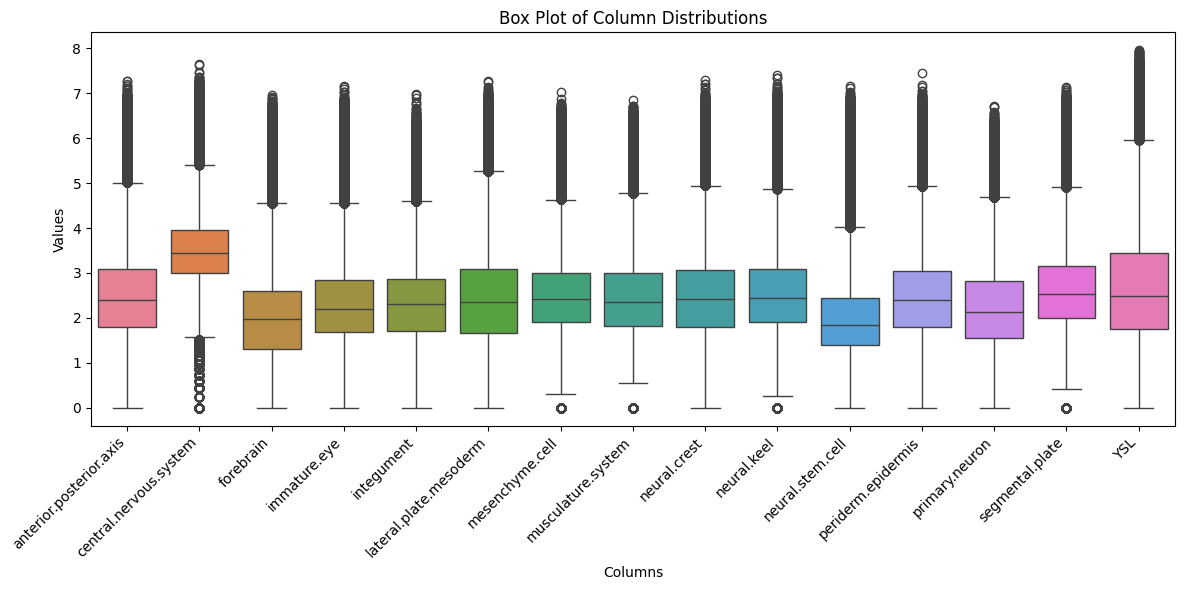

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Define the path to the CSV file
PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(PATH, index_col=0)
print(data.head())
# Plot a box plot for the distributions in each column
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)

# Set the x-tick labels to the column names
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Column Distributions')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()


/home/sasse/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sasse/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


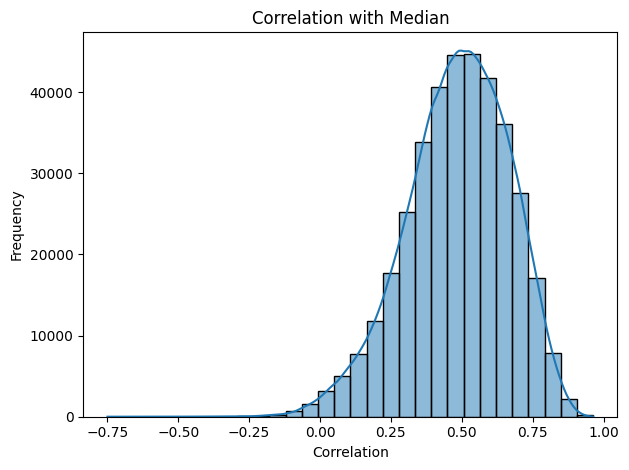

In [12]:
# plot the correlation of each data point across columns to the median
# Calculate the median
median = data.median(axis=0)
# Calculate the correlation of each data point with the median
correlation = data.corrwith(median, axis=1)
sns.histplot(correlation, bins=30, kde=True)
plt.title('Correlation with Median')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

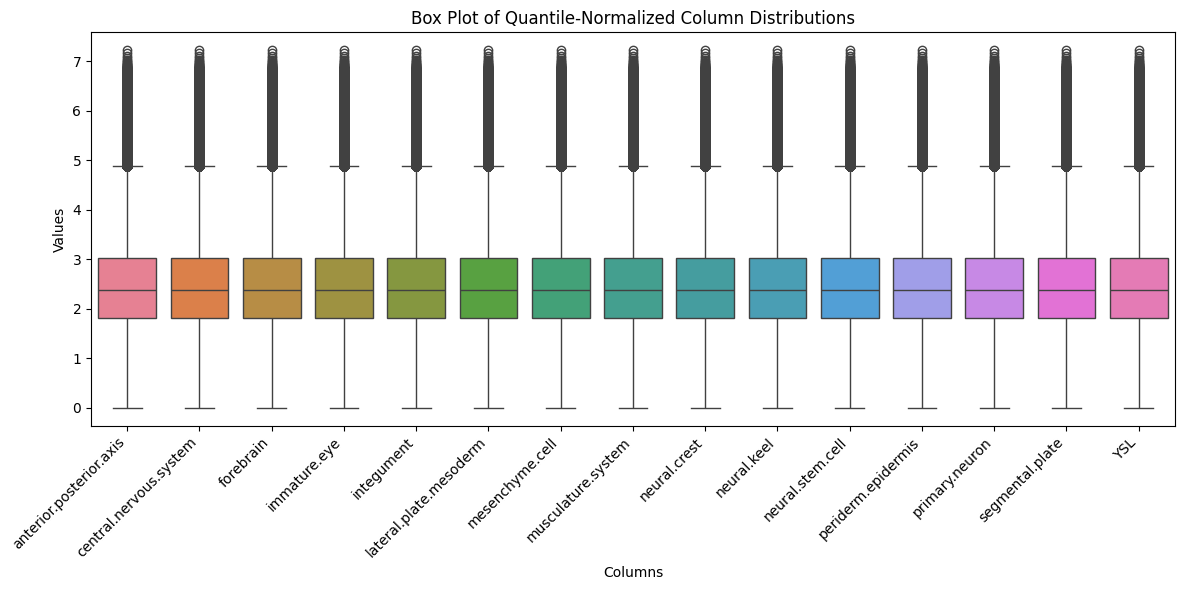

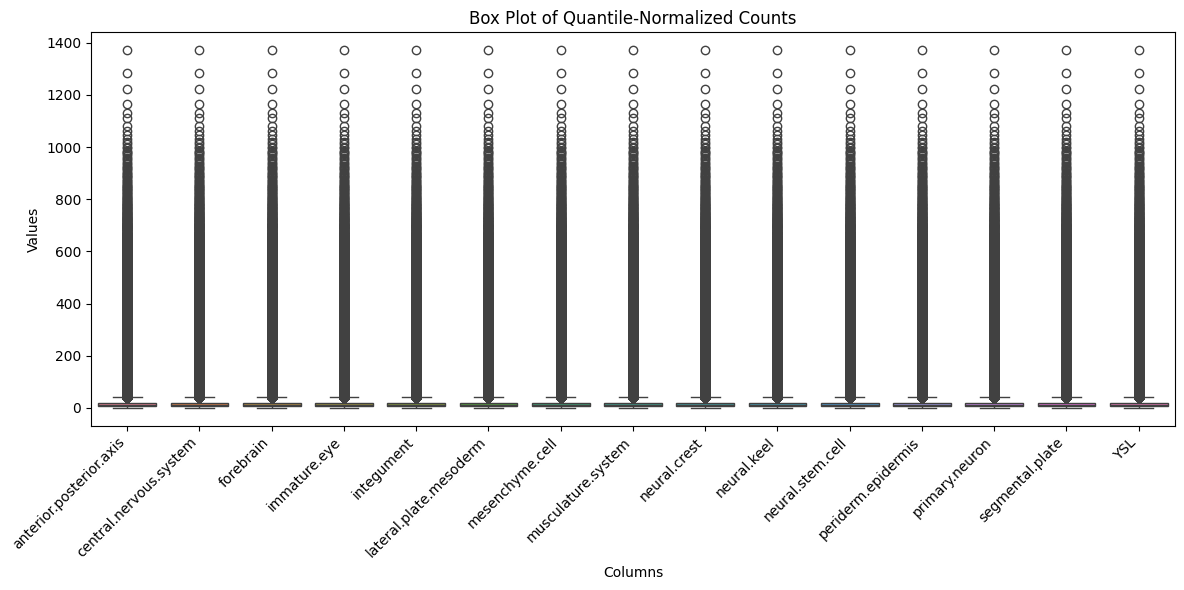

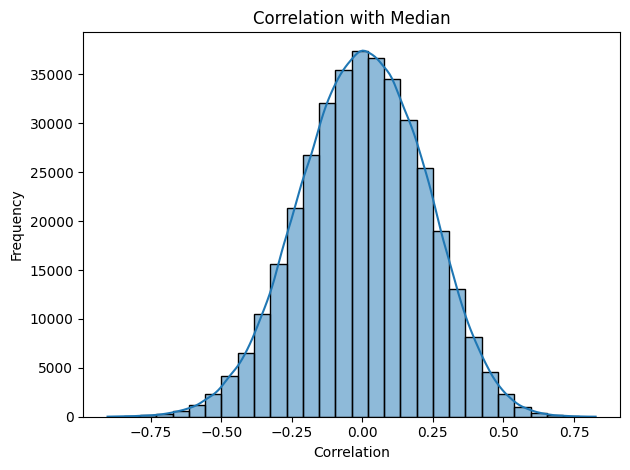

In [13]:
# Perform quantile normalization
def quantile_normalize(df):
    sorted_df = np.sort(df.values, axis=0)
    mean_sorted = np.mean(sorted_df, axis=1)
    ranks = np.argsort(np.argsort(df.values, axis=0), axis=0)
    normalized = mean_sorted[ranks]
    return pd.DataFrame(normalized, columns=df.columns, index=df.index)

normalized_data = quantile_normalize(data)

# Plot a box plot for the quantile-normalized data
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_data)
# Set the x-tick labels to the column names
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Quantile-Normalized Column Distributions')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()

count_normalized_data = np.exp(normalized_data)
# Plot a box plot for the quantile-normalized data in count space
plt.figure(figsize=(12, 6))
sns.boxplot(data=count_normalized_data)
# Set the x-tick labels to the column names
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Quantile-Normalized Counts')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()

# plot the correlation of each data point across columns to the median
# Calculate the median
median = data.median(axis=0)
# Calculate the correlation of each data point with the median
correlation = normalized_data.corrwith(median, axis=1)
sns.histplot(correlation, bins=30, kde=True)
plt.title('Correlation with Median')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
# Save the quantile-normalized data to a new CSV file
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.qn.csv')
normalized_data.index.name = '# position'

normalized_data.to_csv(output_path, index=True)
print(f"Quantile-normalized data saved to {output_path}")

Index(['anterior.posterior.axis', 'central.nervous.system', 'forebrain',
       'immature.eye', 'integument', 'lateral.plate.mesoderm',
       'mesenchyme.cell', 'musculature.system', 'neural.crest', 'neural.keel',
       'neural.stem.cell', 'periderm.epidermis', 'primary.neuron',
       'segmental.plate', 'YSL'],
      dtype='object')
Quantile-normalized data saved to /home/sasse/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.qn.csv


In [54]:
import re
indices = data.index.tolist()
print(indices[:10])
# split the indices at : and -
locations = [re.split('[:-]', i) for i in indices]
print(locations[:10])

# save locations in a bed file with chromosome, start, end, name
with open(f'{os.path.splitext(PATH)[0]}.bed', 'w') as f:
    for l, loc in enumerate(locations):
        if len(loc) == 3:
            f.write(f"{loc[0]}\t{loc[1]}\t{loc[2]}\t{indices[l]}\n")
        else:
            print(f"Skipping invalid entry: {loc}")

['chr1:5232-5732', 'chr1:5787-6287', 'chr1:10088-10588', 'chr1:10991-11491', 'chr1:11895-12395', 'chr1:12474-12974', 'chr1:14016-14516', 'chr1:14704-15204', 'chr1:16672-17172', 'chr1:18404-18904']
[['chr1', '5232', '5732'], ['chr1', '5787', '6287'], ['chr1', '10088', '10588'], ['chr1', '10991', '11491'], ['chr1', '11895', '12395'], ['chr1', '12474', '12974'], ['chr1', '14016', '14516'], ['chr1', '14704', '15204'], ['chr1', '16672', '17172'], ['chr1', '18404', '18904']]


## Create one-hot encodings for modeling

In [ ]:
import os
import numpy as np
import drg_tools as drg
from drg_tools import io_utils as utils
from drg_tools import plotlib as drgplt
from drg_tools import sequence_utils as sutils

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
# extract sequences from bed file and genome file
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 
genome_file = os.path.expanduser('~/data/genomes/danRer11/danRer11.fa.gz')
seq_len = 500
extend_to = 500
extend = int((seq_len - extend_to) / 2)
# Extract sequences from the bed file and genome file

seqnames, seqs = utils.extract_sequences_from_bed(bed_file, genome_file, extend_before = extend, extend_after = extend)

onehot = []
for s, seq in enumerate(seqs):
    onehot.append(sutils.seq_onehot(seq))

# Convert the list of one-hot encoded sequences to a numpy array
onehot = np.array(onehot)
seqnames = np.array(seqnames)
# Print the shape of the one-hot encoded sequences
print(onehot.shape)
# Save the one-hot encoded sequences to a numpy file
output_path = os.path.splitext(bed_file)[0] + '.oh.npz'
# Save the one-hot encoded sequences and names to a numpy file
# call the arrays seqfeatures and genenames for compatibility with the rest of the code
np.savez(output_path, seqfeatures = onehot, genenames = seqnames)
print(f"One-hot encoded sequences saved to {output_path}")




(370058, 500, 4)
One-hot encoded sequences saved to /home/sasse/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.oh.npz


## Create a test set file with 10 data splits based on separate chromosomes

In [6]:
from drg_tools.data_processing import generatetesttrain

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 

if os.path.splitext(bed_file)[1] == '.bed': 
    bed = np.genfromtxt(bed_file, dtype = str)

outname = os.path.splitext(bed_file)[0]+'_tset10.txt'
generatetesttrain(bed[:, 3], bed[:,0], outname, kfold = 10)



Best split 2811.4
0 ['chr1' 'chr7'] 145
1 ['chr13' 'chr5'] -485
2 ['chr20' 'chr3'] -4436
3 ['chr16' 'chr6'] -4673
4 ['chr2' 'chr9'] -4459
5 ['chr8' 'chr17' 'chr25'] 3332
6 ['chr23' 'chr14' 'chr22'] 2309
7 ['chr24' 'chr18' 'chr10'] 1678
8 ['chr21' 'chr19' 'chr12'] 3431
9 ['chr15' 'chr4' 'chr11'] 3166


## Train model with script

In [9]:
import subprocess
import os

PATH = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/psd.bulk.zfish_atac.10hpf.lg1x.csv')
bed_file = f'{os.path.splitext(PATH)[0]}.bed' 

inseq=os.path.splitext(bed_file)[0]+'.oh.npz' # one hot encoded sequences
target=os.path.splitext(PATH)[0]+'.qn.csv' # Data matrix with data points in rows, and tracks in columns
crossval_file=os.path.splitext(PATH)[0]+'_tset10.txt' # Can either be number of folds, or a file with # Set N \n, followed by a line with all data point names that are in this set separated by a space. 
fold=0 # fold to use for testing, 0 for all
# Set the parameters for the model
seq_len=500 # length of the sequences

model_parameters = {
'l_kernels' : 19, # kernel size
'kernel_bias' : False,
'reverse_complement' : True, # needs to be assigned with --reverse_complement
'num_kernels' : 300, # Number of kernels in first layer
'pooling_size': 2, # pooling size after first layer
'dilated_convolutions' : 5, # number of dilated conv. blocks
'l_dilkernels' : 7,
'dilations' : [1,2,4,8,16], # dilation rates for each block
'dilpooling_residual' :  1, # number conv blocks to skip in each residual
'dilmax_pooling' : 0, # max pooling size after each conv. block
'transformer_convolutions' : 5, # number of convolutions with max pooling after first layers of residual blocks
# select as l_seq/pooling_size /trmax_pooling**transformer_convolutions = 10
'l_trkernels' : 7,
'trmax_pooling' : 2,
'trpooling_residual' : 6, # 
'fclayer_size' : 512, # dimension for fully connected layer
'nfc_layers': 2, # number of fully connected layers after conv. blocks
'conv_batch_norm' : False, # batch normalization after each conv. block
}

training_parameters = {
'epochs' : 100, # training epochs
'patience' : 5, # patience for early stopping
'finetuning' : False, # Fine tuning with reduced lr
'keepmodel' : True, # Keep model parameters after training and computation of performance etc. 
'lr' : 0.000003, # learning rate
'device' : "cuda:0", # device to use for training
'batchsize' : 64, # batch size
'validation_loss': 'Correlationclass',
'optimizer' : 'SGD', # optimizer to use
'optim_params' : 0.9, # momentum
'outclass' : 'Linear', # output class
'shift_sequence' : 5, # shift sequence for data augmentation
'random_shift' : True,
'fc_dropout' : 0.1, # dropout after conv. layers
'warm_up_epochs' : 3 # warm up epochs
}

# Combine individual choices to provide for the model
cnn="+".join(f"{key}={value}" for key, value in model_parameters.items())
training="+".join(f"{key}={value}" for key, value in training_parameters.items())

VARS=cnn+'+'+training
VARS=VARS.replace(' ', '')
print(VARS)

script_path = os.path.expanduser('~/Git/DRG/scripts/train_models/run_cnn_model.py')
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
#process = subprocess.Popen(["python", script_path, inseq, target, '--delimter', ',', '--reverse_complement', "--crossvalidation", crossval_file, str(fold), '0', "--cnn", VARS, "--save_correlation_perpoint", "--save_correlation_perclass", '--outdir', output_path])
#process = subprocess.run(["python", script_path, inseq, target, '--delimter', ',', '--reverse_complement', "--crossvalidation", crossval_file, str(fold), '0', "--cnn", VARS, "--save_correlation_perpoint", "--save_correlation_perclass", '--outdir', output_path])
process = subprocess.run(["python", script_path, inseq, target, '--delimter', ',',  "--crossvalidation", crossval_file, str(fold), '0', "--cnn", VARS, "--save_correlation_perpoint", "--save_correlation_perclass", '--outdir', output_path])


#if process.poll() is None:
    #print("Process is still running")
#else:
    #print("Process has terminated")
# Terminate the subprocess
#process.terminate()  # Gracefully terminate the process


l_kernels=19+kernel_bias=False+reverse_complement=True+num_kernels=300+pooling_size=2+dilated_convolutions=5+l_dilkernels=7+dilations=[1,2,4,8,16]+dilpooling_residual=1+dilmax_pooling=0+transformer_convolutions=5+l_trkernels=7+trmax_pooling=2+trpooling_residual=6+fclayer_size=512+nfc_layers=2+conv_batch_norm=False+epochs=100+patience=5+finetuning=False+keepmodel=True+lr=3e-06+device=cuda:0+batchsize=64+validation_loss=Correlationclass+optimizer=SGD+optim_params=0.9+outclass=Linear+shift_sequence=5+random_shift=True+fc_dropout=0.1+warm_up_epochs=3
Input shapes X: (370058, 4, 500)
Output shapes Y: (370058, 15)
Train 296388
Test 36520
Val 37150
Device cuda:0
ALL file names /home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc5i1d1-2-4-8-16s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr3e-06SGD0.9bs64-F
In features 4 510
Convolutions 300 510
Pooling 300 255
2nd convolutions 300 255
Convolution after attention 300 8
Be

Traceback (most recent call last):
  File "/home/sasse/Git/DRG/scripts/train_models/run_cnn_model.py", line 491, in <module>
    model.fit(X[trainset], Ytraintomodel, XYval = [X[valset], Yvaltomodel], sample_weights = weights)
  File "/home/sasse/Git/DRG/drg_tools/cnn_model.py", line 1102, in fit
    self.saveloss = fit_model(self, X, Y, XYval = XYval, sample_weights = sample_weights, loss_function = self.loss_function, validation_loss = self.validation_loss, loss_weights = self.loss_weights, val_loss_weights = self.val_loss_weights, batchsize = self.batchsize, device = self.device, optimizer = self.optimizer, optim_params = self.optim_params, optim_weight_decay = self.optim_weight_decay, verbose = self.verbose, lr = self.lr, kernel_lr = self.kernel_lr, hot_start = self.hot_start, warm_start = self.warm_start, outname = self.outname, adjust_lr = self.adjust_lr, patience = self.patience, init_adjust = self.init_adjust, keepmodel = self.keepmodel, load_previous = self.load_previous, writ

KeyboardInterrupt: 

In [ ]:
process.terminate()

## Look at training curves

/home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F_loss.txt


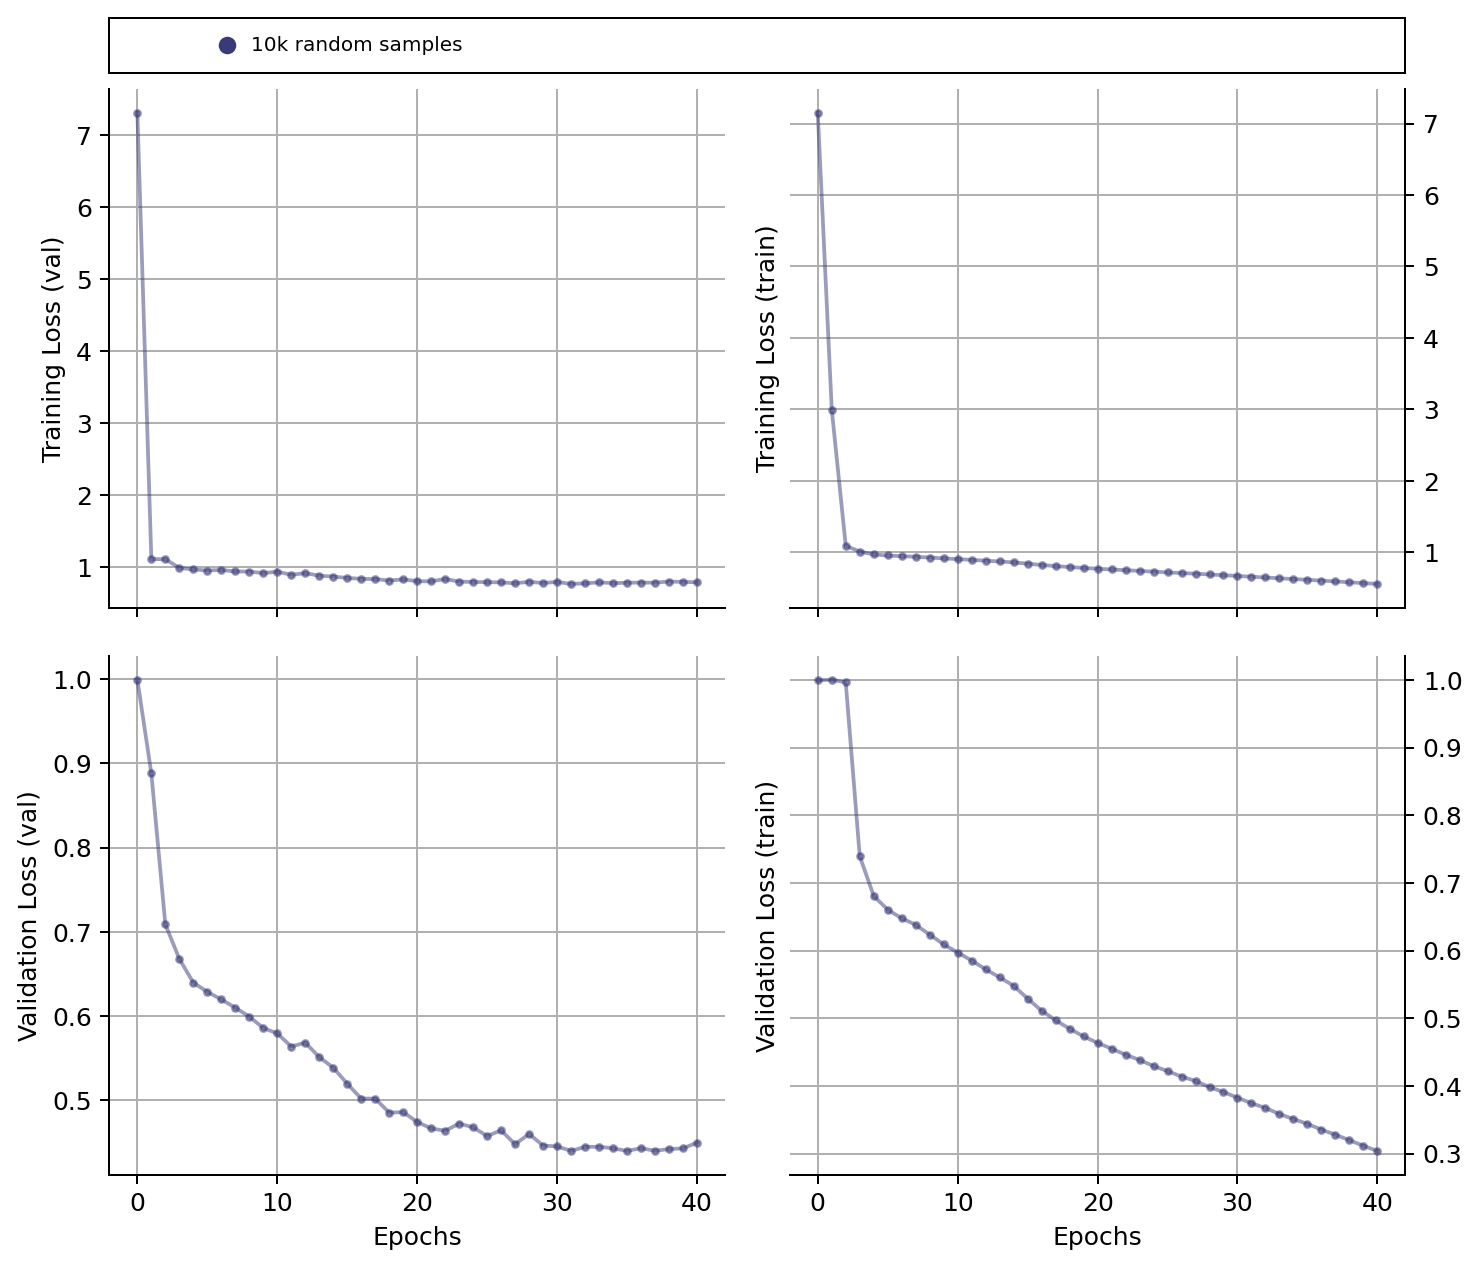

In [11]:
from drg_tools.plotlib import plot_losses
import os
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
losslog = os.path.join(output_path, model_stem) + '_loss.txt'

# Plot the losses
plot_losses(losslog, '10k random samples', percentages=False, combine_sets=False, logx=False, adjust_axis=False, savefig=None)


## Look at the performance of the trained model

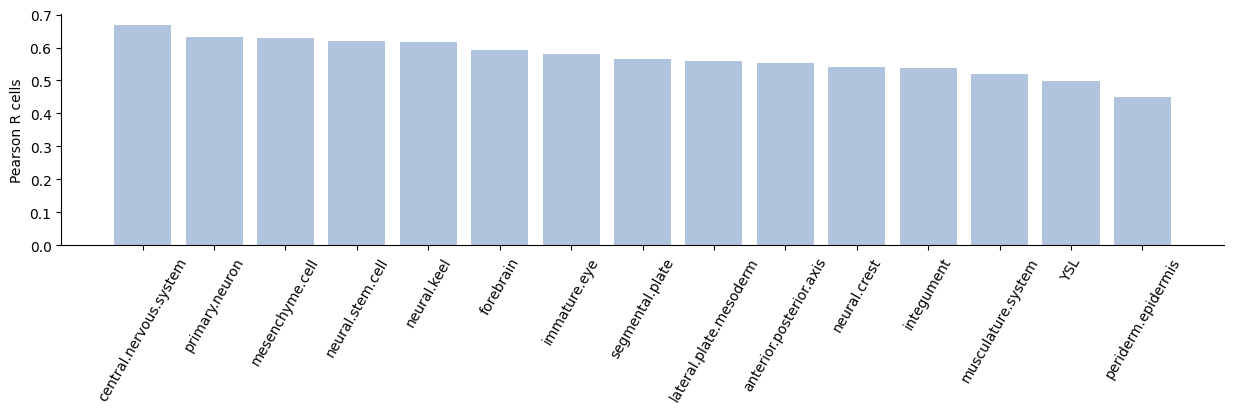

In [14]:
from drg_tools.plotlib import _bar_plot
import os
import numpy as np
import matplotlib.pyplot as plt
# Load the correlation data
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
trackcorr = os.path.join(output_path, model_stem) + '_clss_corr_tcl0.txt'
corrvalues = np.genfromtxt(trackcorr, dtype = str)
sort = np.argsort(corrvalues[:,1].astype(float))
#print(corrvalues)
ax = _bar_plot(1.-corrvalues[sort,1].astype(float), ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues[sort,0], rotation = 60)
plt.show()


yaxis 1490.0


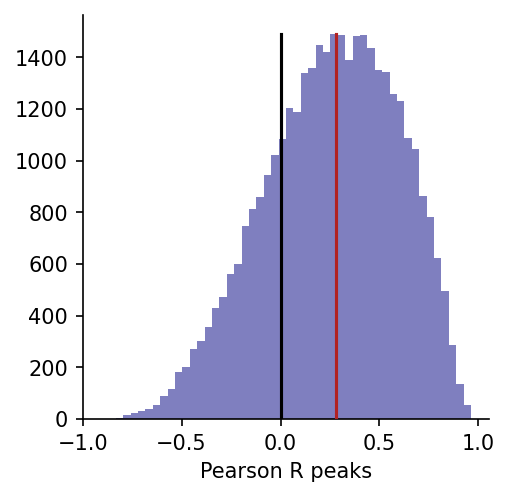

In [15]:
from drg_tools.plotlib import plotHist
import os
import numpy as np
import matplotlib.pyplot as plt

# Load the correlation data
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'

peakcorr = os.path.join(output_path, model_stem) + '_pnt_corr_tcl0.txt'
corrvalues = np.genfromtxt(peakcorr, dtype = str)
ax = plotHist(1.-corrvalues[:,1].astype(float), add_median = True, add_yaxis= True, xlabel = 'Pearson R peaks', bins = 50)
plt.show()

## Load model and look at attributions for neural creast cells

ALL file names CNNmodel_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F
In features 4 510
Convolutions 300 510
Pooling 300 255
2nd convolutions 300 255
Convolution after attention 300 8
Before FCL 2400
outclasses 15
Loaded convolutions.conv1d.weight with convolutions.conv1d.weight
Loaded convolution_layers.convlayers.Conv0.conv1d.weight with convolution_layers.convlayers.Conv0.conv1d.weight
Loaded trconvolution_layers.convlayers.Conv0.conv1d.weight with trconvolution_layers.convlayers.Conv0.conv1d.weight
Loaded trconvolution_layers.convlayers.Conv0.conv1d.bias with trconvolution_layers.convlayers.Conv0.conv1d.bias
Loaded trconvolution_layers.convlayers.Conv1.conv1d.weight with trconvolution_layers.convlayers.Conv1.conv1d.weight
Loaded trconvolution_layers.convlayers.Conv1.conv1d.bias with trconvolution_layers.convlayers.Conv1.conv1d.bias
Loaded trconvolution_layers.convlayers.Conv2.conv1d.weight with trconvolution_layers.convlayers.Con

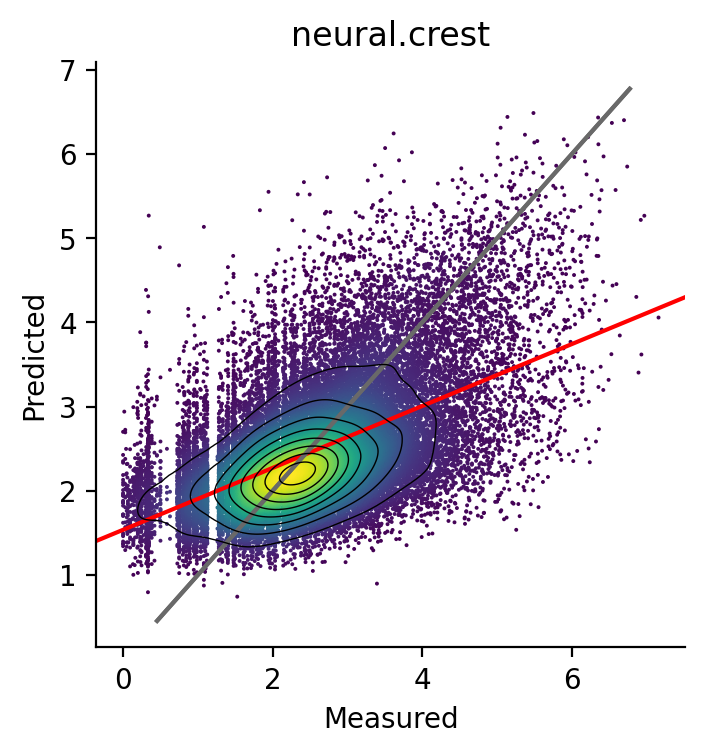

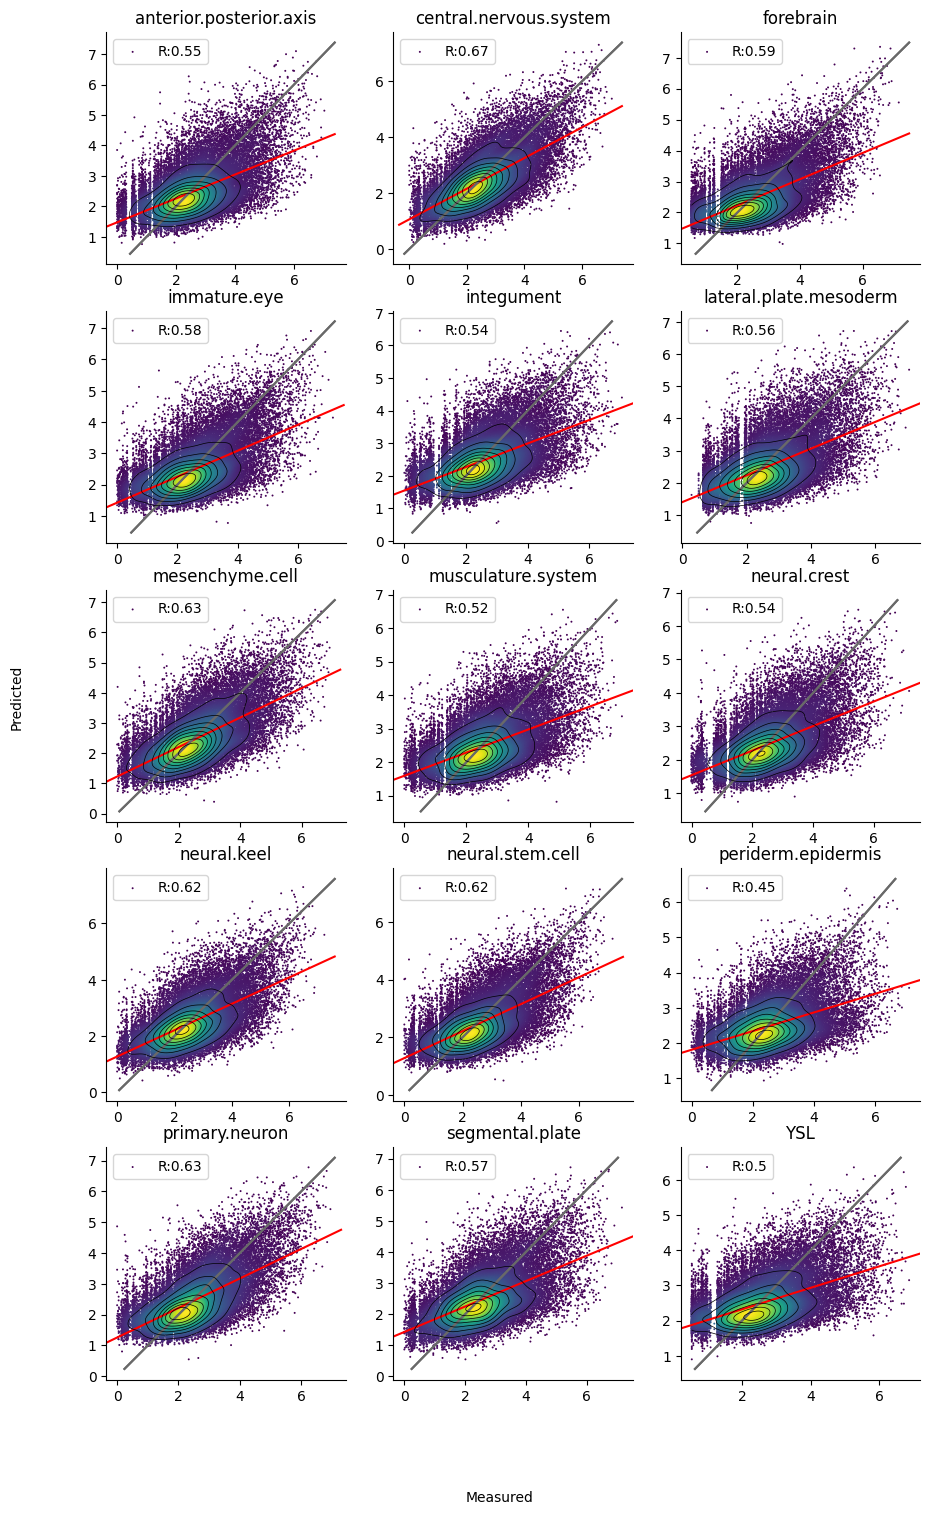

In [2]:
from drg_tools.model_utils import get_device, process_cnn_arguments, load_parameters
from drg_tools.cnn_model import cnn 
from drg_tools.io_utils import readin
from drg_tools.model_training import create_sets, batched_predict
import os

data_stem = 'psd.bulk.zfish_atac.10hpf.lg1x'
data_dir = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/')
data_file = os.path.join(data_dir, data_stem) +'.qn.csv'

output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'

# model training saved two files, one with the weights and biases (pth), and one with the arguments that defined the model architecture
model_args = os.path.join(output_path, model_stem) +  '_model_params.dat'
model_pth = os.path.join(output_path, model_stem) + '_parameter.pth'

# Load the model arguments
init_args = process_cnn_arguments(model_args, replace_arguments=None)
init_args['generate_paramfile'] = False
device = 'cuda:0' #get_device()
#print(device)
#for ia in init_args:
#    print(ia, init_args[ia]) 

# Create the model
model = cnn(**init_args)

# Load the model parameters
load_parameters(model, model_pth, translate_dict = None, allow_reduction = False, exclude = [], include = False)
# Set the model to evaluation mode
model.eval()
# Set model to device
model.to(device)    

# Load the one-hot encoded sequences and measured data and align data points
oh_file = os.path.join(data_dir, data_stem) + '.oh.npz'
X, Y, inputnames, inputfeatures, header = readin(oh_file, data_file, delimiter=',', return_header=True, assign_region=True, n_features=4, combinex=True)

# Check the shape of the data
print(X.shape)
print(Y.shape)
print(inputnames.shape)
print(header)

# Split the data into training and test sets as before
crossval_file=os.path.join(data_dir, data_stem)+'_tset10.txt' # Can either be number of folds, or a file with # Set N \n, followed by a line with all data point names that are in this set separated by a space. 
trainset, testset, valset = create_sets(len(X), crossval_file, 0, Yclass = None, genenames = inputnames)
print('Train', len(trainset))
print('Test', len(testset))
print('Val', len(valset))

# Make predictions with the model using 
test_predictions = batched_predict(model, X[testset], batchsize=128, device=device, shift_sequence=model.shift_sequence, random_shift=model.random_shift)

# Plot predictions versus measured data in a scatter plot
import matplotlib.pyplot as plt
import numpy as np
from drg_tools.plotlib import scatterPlot, plot_scatter
nc_index = np.where(np.array(header) == 'neural.crest')[0][0]

singlefig = scatterPlot(Y[testset,nc_index], test_predictions[:, nc_index], title = 'neural.crest', xlabel = 'Measured', ylabel = 'Predicted', 
            include_fit = True, include_mainvar = False, diagonal = True, plot_axis = False, 
            boxplot_x = None, boxplot_y = None, contour = True, pos_neg_contour = False, 
            color=None, edgecolor = 'silver', cmap = None, sort_color = 'abshigh', 
            color_density = True, vlim = None, sizes = 2, alpha = None, 
            lw = 0., yticklabels = None, yticks = None, xticklabels = None, 
            xticks = None, grid = False, xlim = None, ylim =None, xscale = None, legend = False, 
            add_text = None, yscale = None, ax = None, dpi = 200)

allfig = plot_scatter(list(Y[testset].T), list(test_predictions.T), titles = header, xlabel = 'Measured', ylabel = 'Predicted', 
                      sizes = 2, contour = True, color_density = True, color = 'grey', lw = 0., legend = True, 
                      include_fit = True, include_mainvar = False, diagonal = True)
plt.show()




## Selected trusted well-predicted data points

Selected 12 sequences for neural crest
TISM time for (12, 1, 4, 500) 1 0.06938886642456055
Deeplift time for (12, 1, 4, 500) 1 0.017187833786010742
ISM time for (12, 4, 500, 1) 1 3.0465495586395264
IntegratedGradients (12, 1, 4, 500) 0.25406384468078613
TISM time for (12, 1, 5, 50) 1 0.06415820121765137
Condensed grad attributions of shape (12, 1, 5, 50)


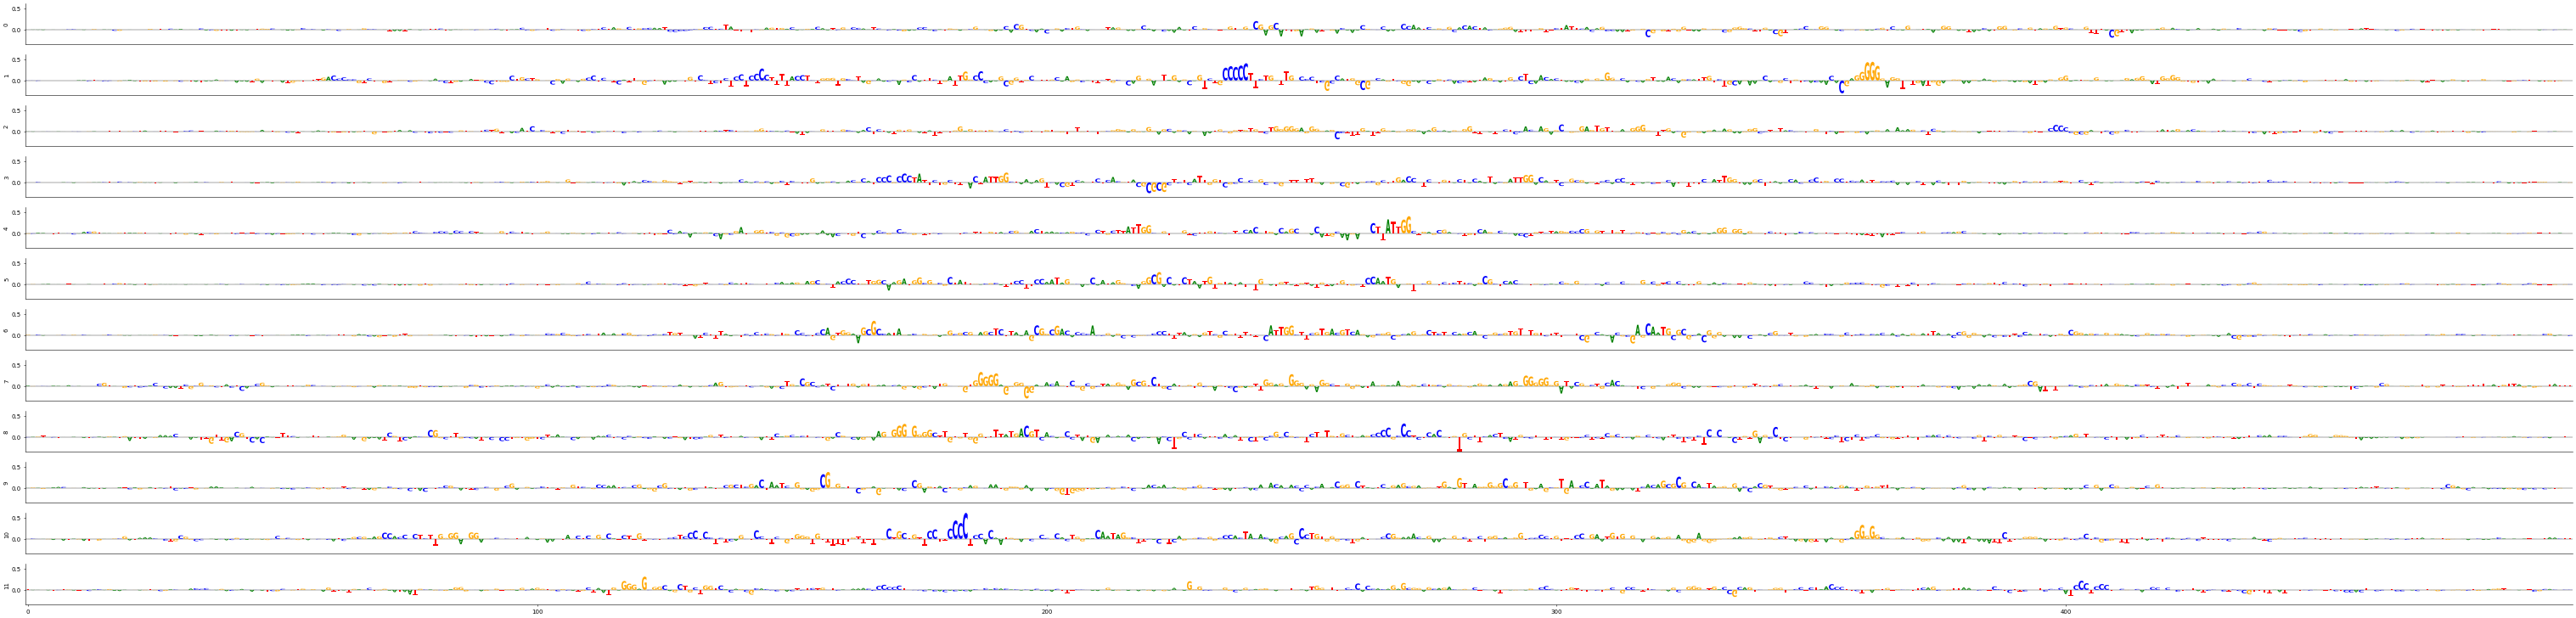

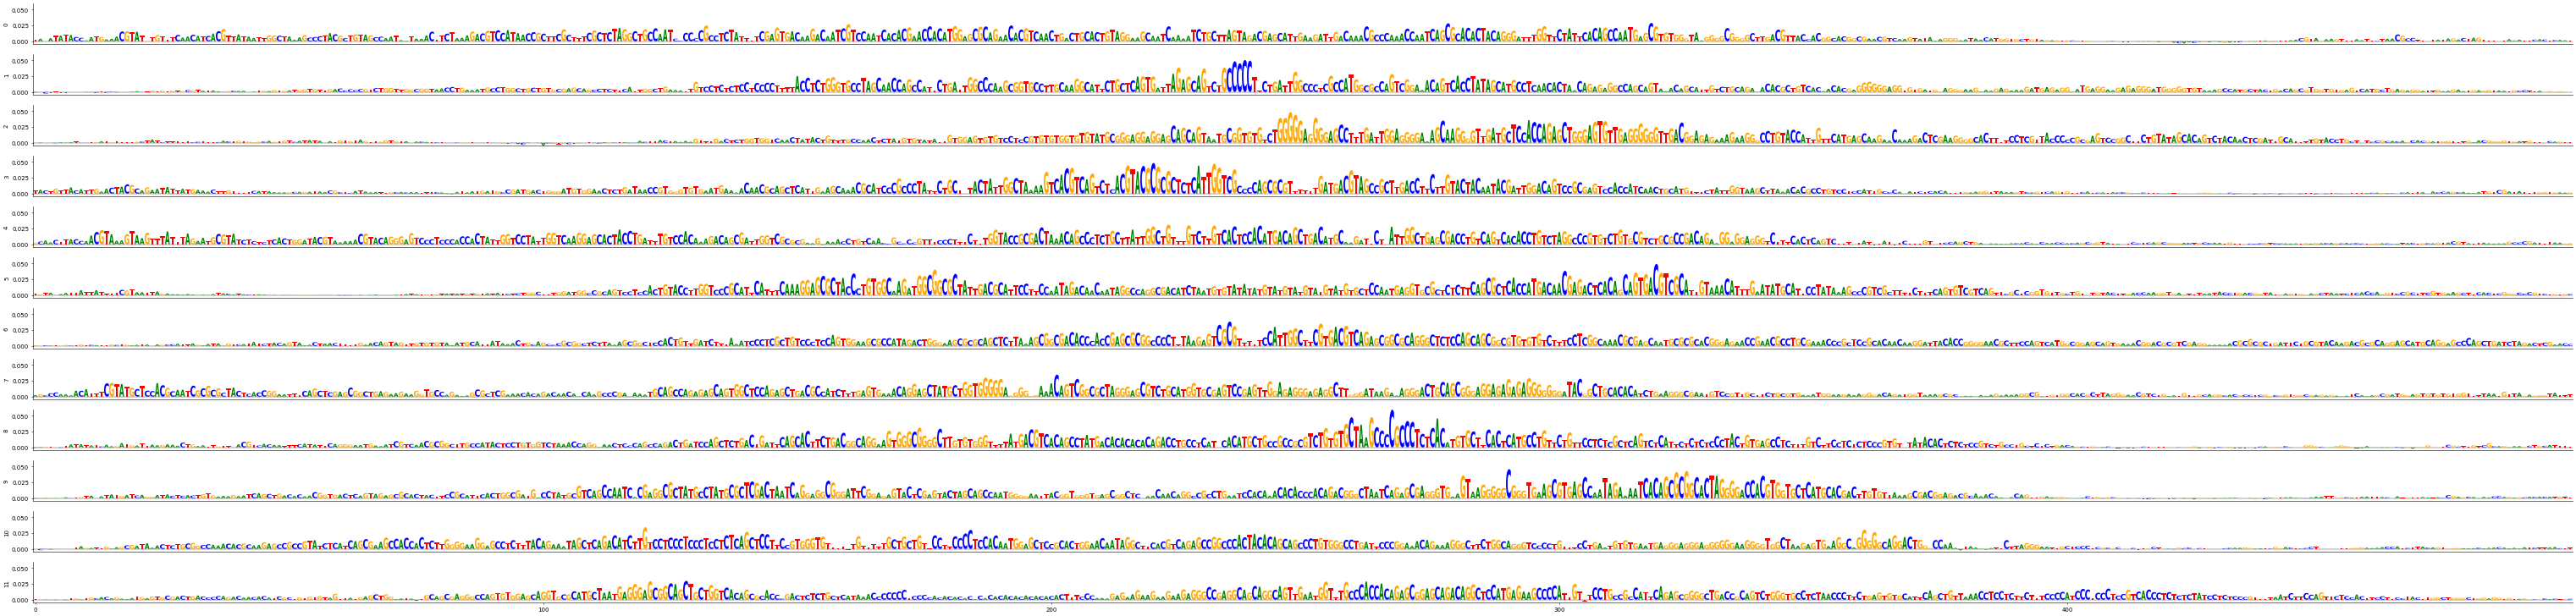

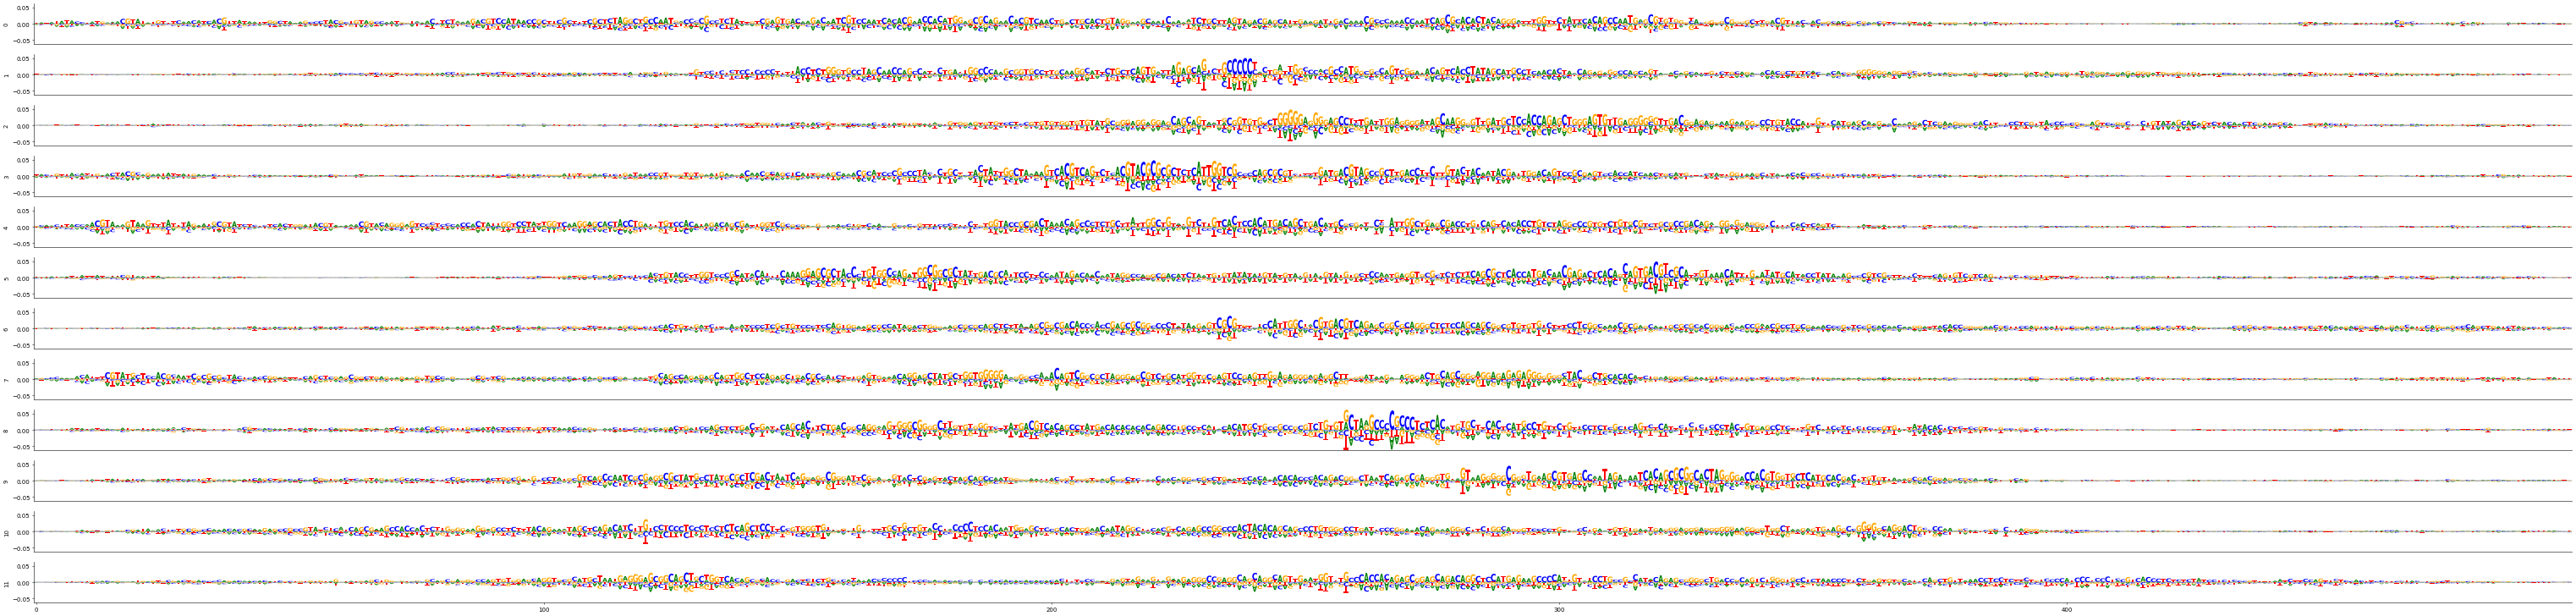

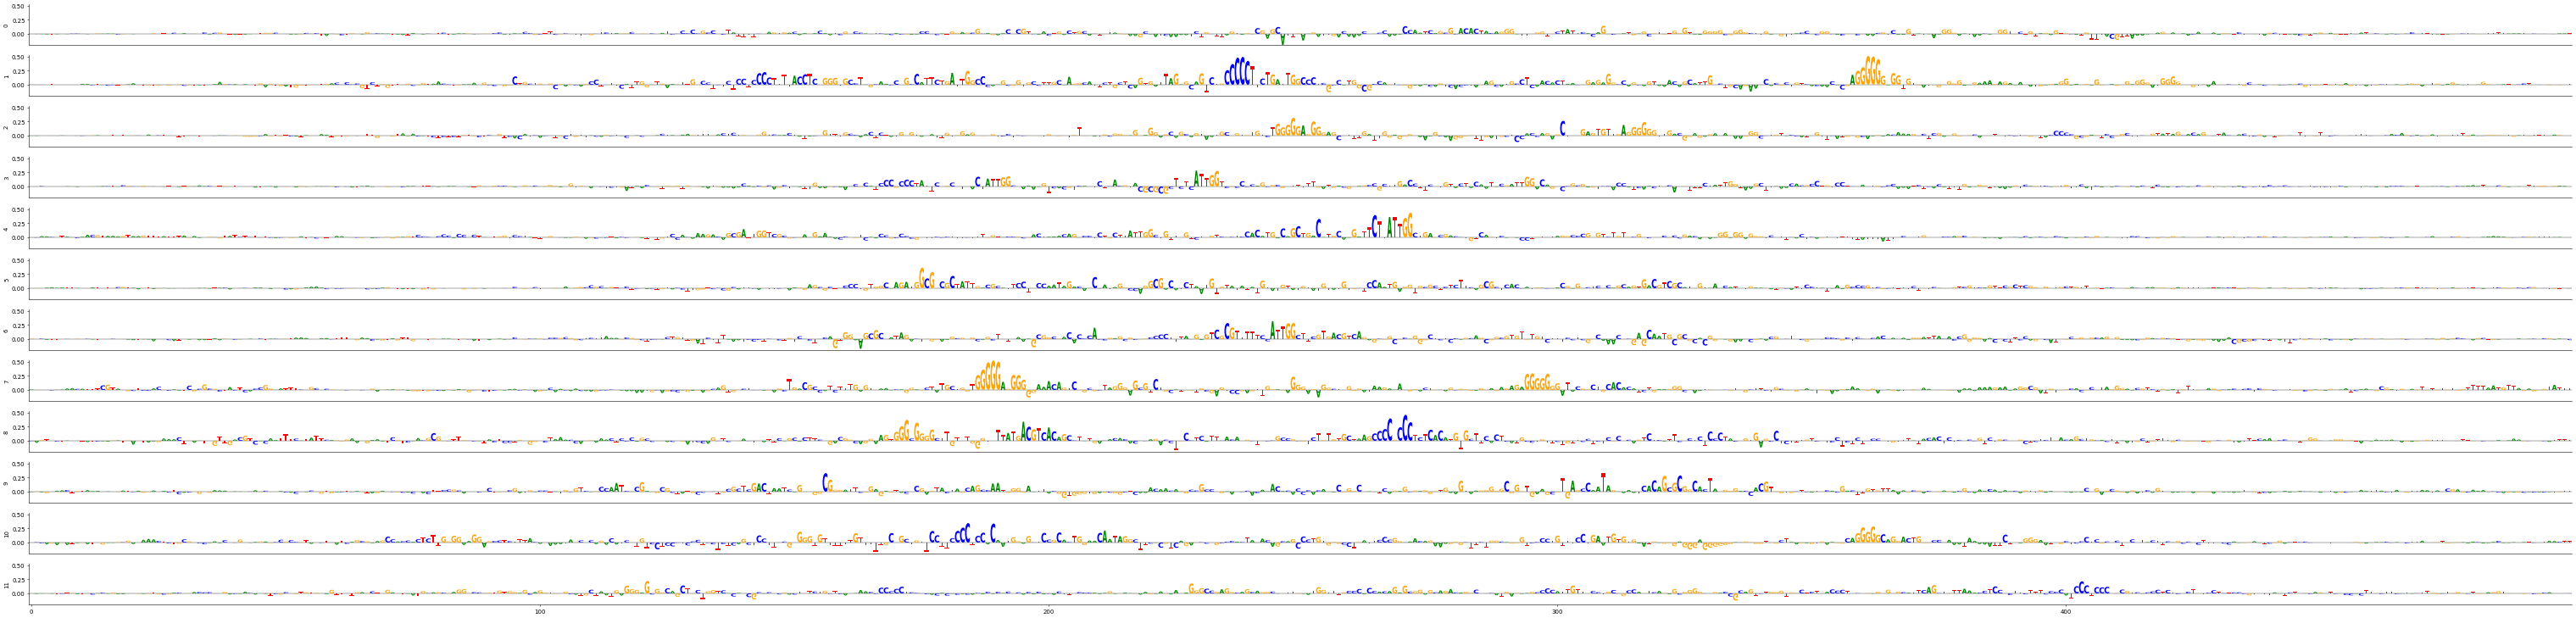

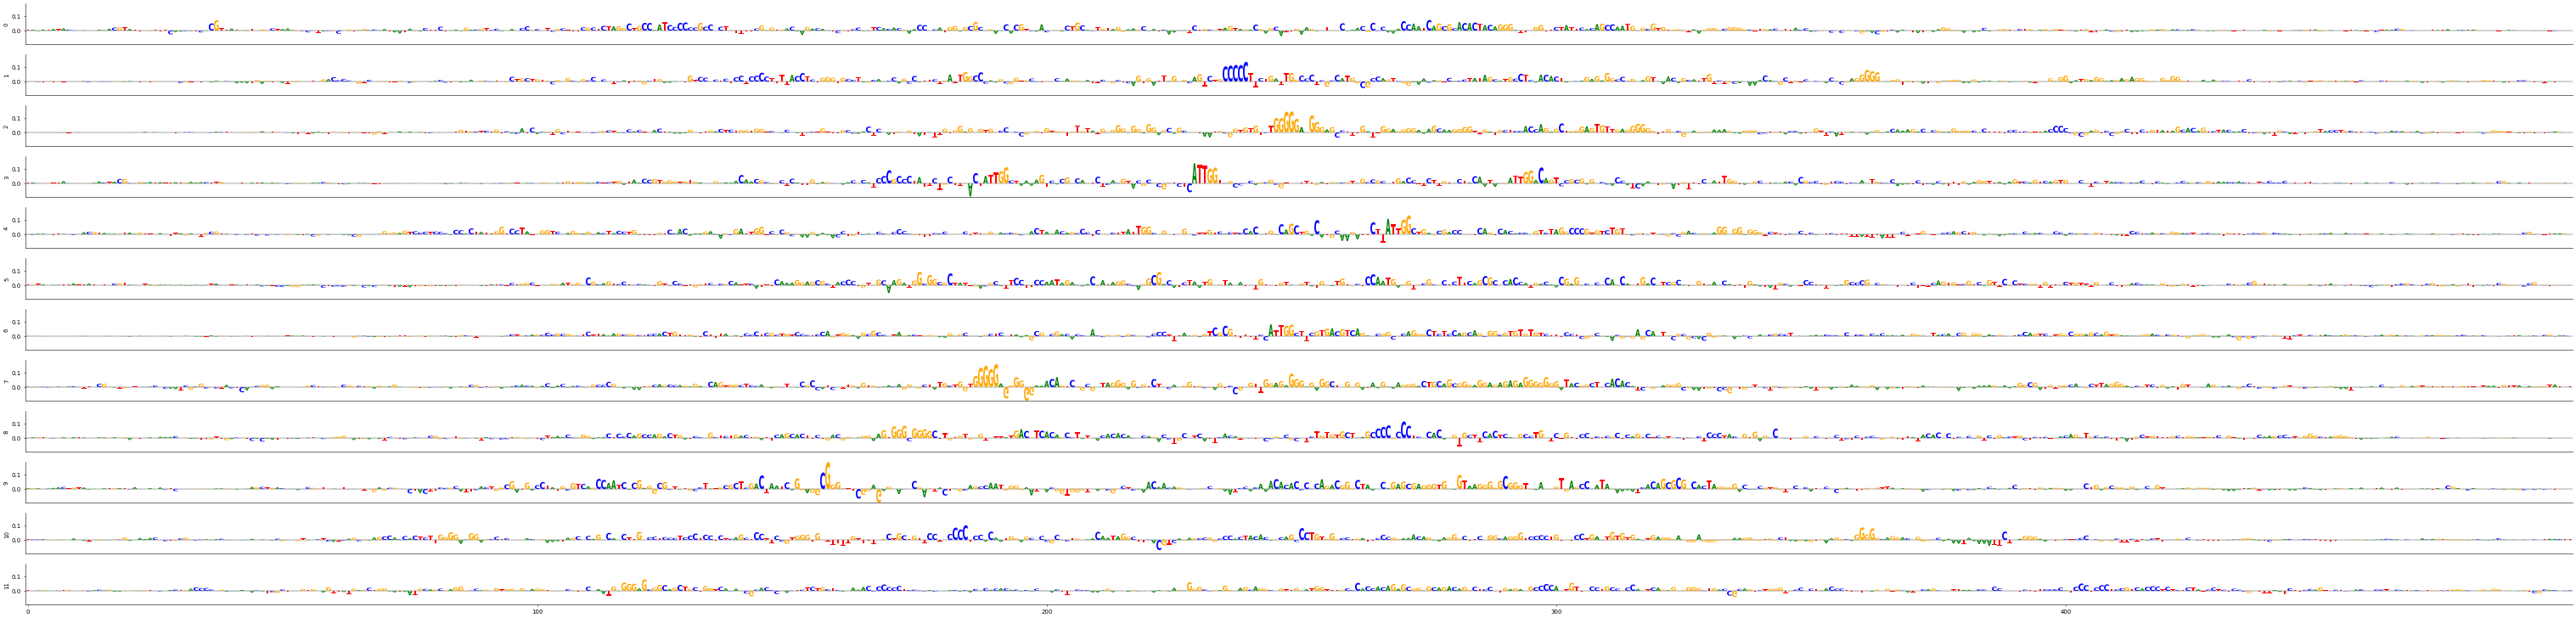

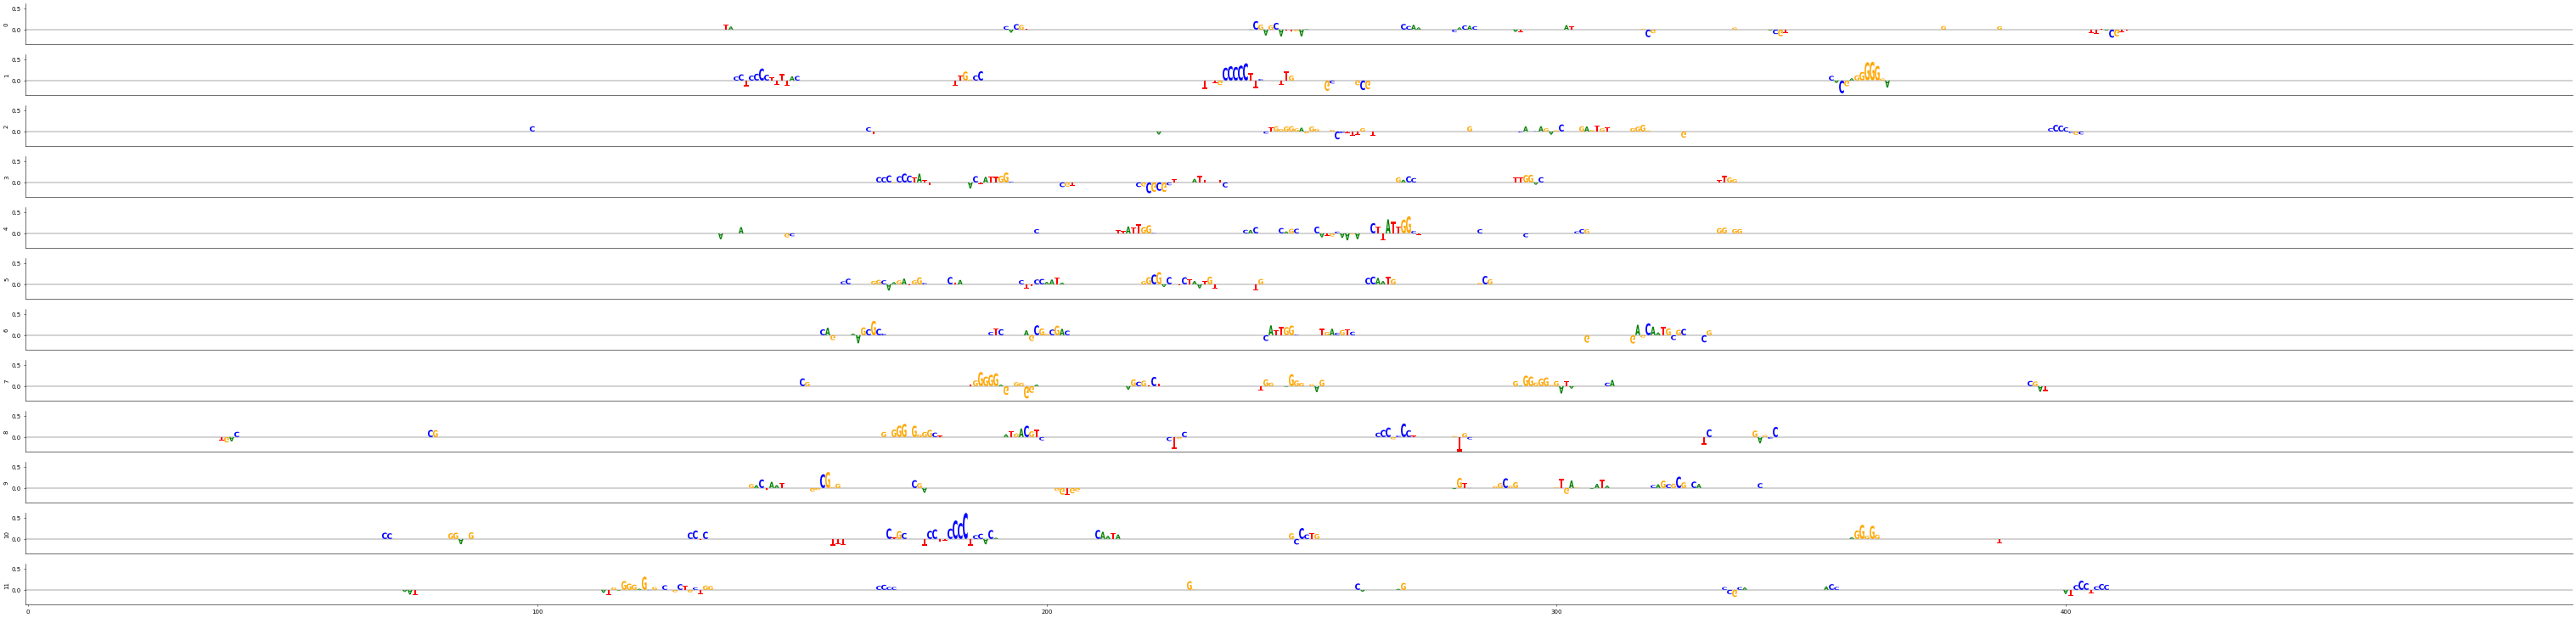

In [5]:
# Select set of sequences for neural.crest
import numpy as np
nc_index = list(header).index('neural.crest')

# Select sequence with highest signal and close to measured
testmask = (np.abs(Y[testset,nc_index]-test_predictions[:, nc_index])<1.) & (test_predictions[:, nc_index] > 6.)
print(f'Selected {int(np.sum(testmask))} sequences for neural crest')
# indices of sequences
selcted_indices = testset[testmask]

# Get the selected sequences
selected_sequences = X[selcted_indices]
# Get the selected names
selected_names = inputnames[selcted_indices]

from drg_tools.interpret_cnn import takegrad, ism, deeplift, captum_sequence_attributions

# Confirm predictions
#model.eval()
#print(model.predict(selected_sequences))

gradattr = takegrad(selected_sequences, model, tracks = nc_index, device=device, output='attributions')
deepliftattr = deeplift(selected_sequences, model, tracks = nc_index, device=device, output='attributions')
ismattr = ism(selected_sequences, model, tracks = nc_index, device=device, output='attributions') 
igattr = captum_sequence_attributions(selected_sequences, model, tracks = nc_index, attribution_method = 'IntegratedGradients', 
                                      basefreq = 0.25, batchsize = None, output = 'attributions')
# plot the attributions
import matplotlib.pyplot as plt
from drg_tools.plotlib import plot_attribution_maps, correct_sparse_attributions
# Change the dimension of attributions
gradattr = np.transpose(gradattr[:,0], axes = (0,2,1)) 
figgrad = plot_attribution_maps(gradattr, seq = np.transpose(selected_sequences, axes = (0,2,1)), motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)

#figgradall = plot_attribution_maps(gradattr, seq = None, motifs = None, experiments = None, 
#                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
#                          xtick_range = None, barplot = None, heatmap = False)

# DEEPLIFT DOES NOT WORK FOR ALL MODEL ARCHITECTURES; ALWAYS CHECK WITH ISM
deepliftattr = np.transpose(deepliftattr[:,0], axes = (0,2,1)) 
figdl = plot_attribution_maps(deepliftattr, seq = np.transpose(selected_sequences, axes = (0,2,1)), motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)
figdlall = plot_attribution_maps(deepliftattr, motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)


ismattr = np.transpose(ismattr[:,0], axes = (0,2,1)) 
figism = plot_attribution_maps(ismattr, seq = np.transpose(selected_sequences, axes = (0,2,1)), motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)

iggattr = np.transpose(igattr[:,0], axes = (0,2,1)) 
figigg = plot_attribution_maps(iggattr, seq = np.transpose(selected_sequences, axes = (0,2,1)), motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)

# To save memory or disc space, we can also tell the algorithms to return only the highest 100 positions
gradattrtop = takegrad(selected_sequences, model, tracks = nc_index, device=device, output='attributions', top = 50)
print(f'Condensed grad attributions of shape {gradattrtop.shape}')
# Before plotting, we need to undense this attribution format, and use zeros where nothing was saved.
gradattrtopvis = correct_sparse_attributions(np.transpose(gradattrtop[:,0], axes = (0,2,1)), n_channels = 4, l_seq = 500)
figgradtop = plot_attribution_maps(gradattrtopvis, seq = np.transpose(selected_sequences, axes = (0,2,1)), motifs = None, experiments = None, 
                          vlim = None, unit = 0.15, ratio = 10, ylabel = None,
                          xtick_range = None, barplot = None, heatmap = False)


plt.show()

## Systematically extract motifs from the computed sequence attributions


Selected 433 sequences that differ at most 1 in cell types where they have signal over 5
TISM time for (433, 15, 4, 500) 15 14.834384679794312
Estimated cutoff for significance from standard deviation 0.12194460667669772


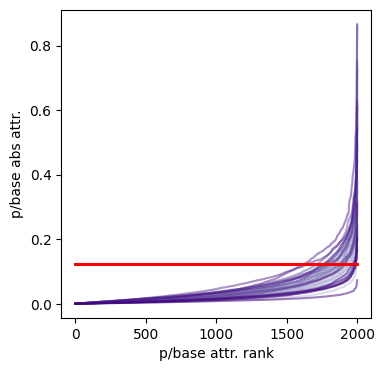

(433, 15, 4, 500) (433, 4, 500)
(433, 15, 500)


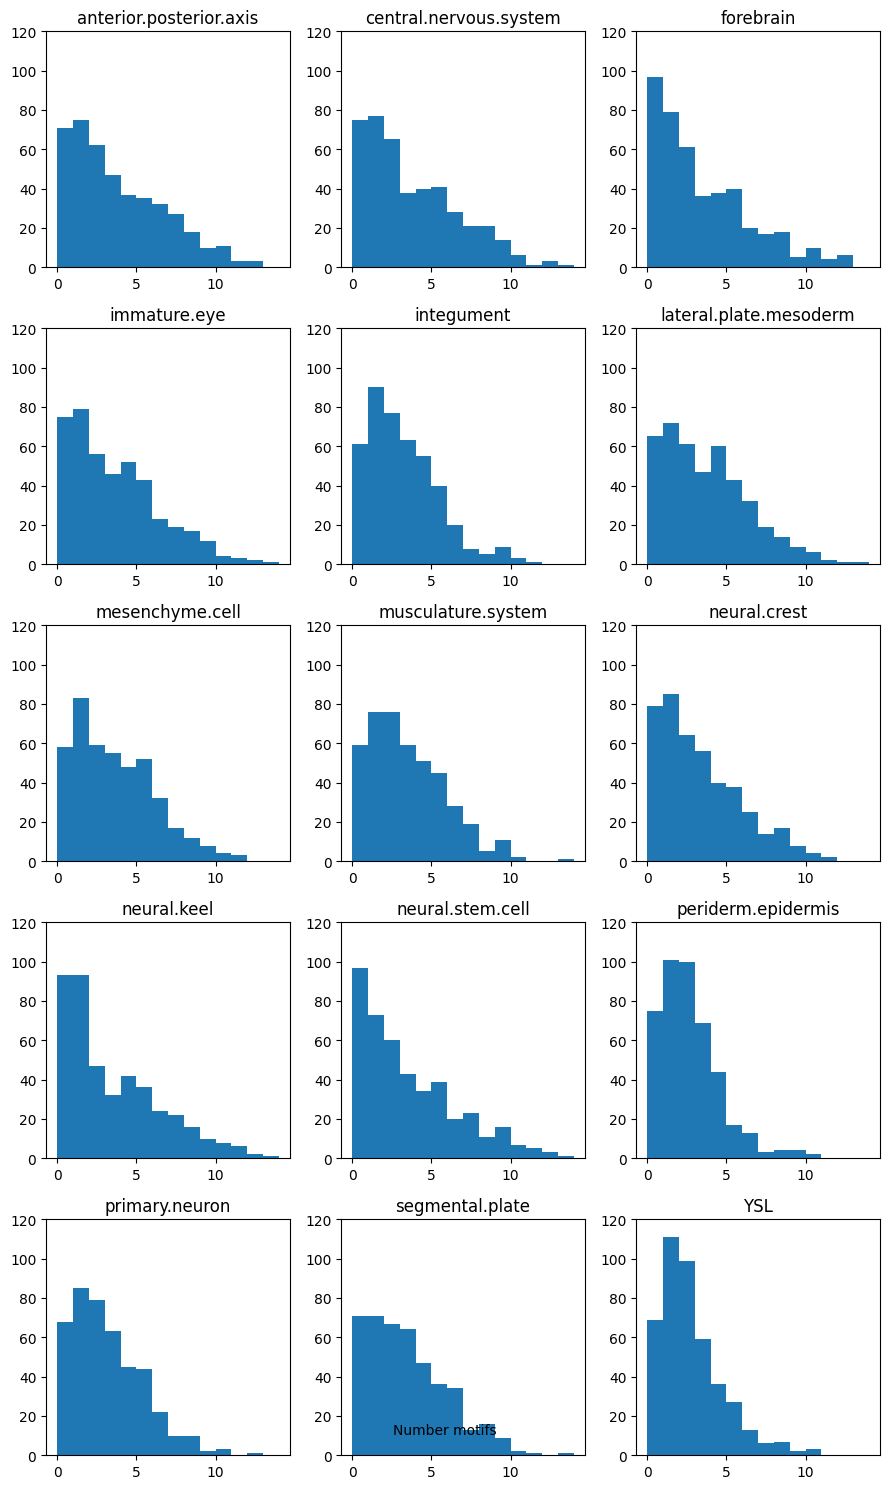

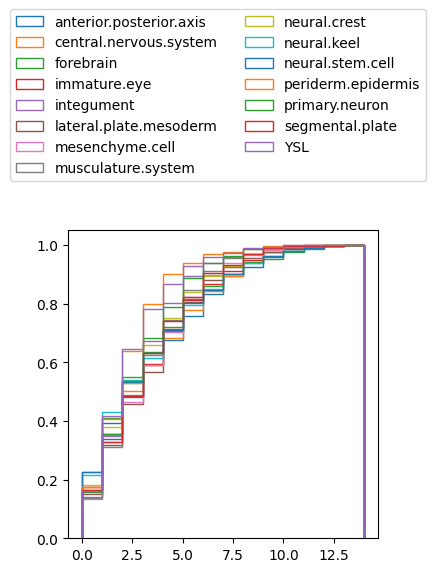

In [ ]:
# TODO make the find function work with sparse attributions

from drg_tools.motif_analysis import find_motifs
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl

# Select sequence with highest signal and close to measured
testmask = np.sum((np.abs(Y[testset]-test_predictions)<1.) * (test_predictions > 5.), axis = 1) >1
print(f'Selected {int(np.sum(testmask))} sequences that differ at most 1 in cell types where they have signal over 5')
# indices of sequences
selcted_indices = testset[testmask]

# Get the selected sequences
selected_sequences = X[selcted_indices]
# Get the selected names
selected_names = inputnames[selcted_indices]

# Compute gradients for all tracks
gradattr = takegrad(selected_sequences, model, tracks = None, device='cuda:0', output='attributions')

sigcut = 1.95 * np.mean(np.std(gradattr, axis = (-1,-2)))
print(f'Estimated cutoff for significance from standard deviation {sigcut}')
# Plot distribution of absolute attribution effect against their rank
# To determine best estimate for significance cut off 
nd = 50
rt = 8
colors = pl.cm.Purples(np.linspace(0,1,nd))
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
for i in range(nd):
    absgrad = np.abs(gradattr[i,rt].flatten())
    absgrad = np.sort(absgrad)
    rank = np.argsort(np.argsort(absgrad))
    ax.plot(rank, absgrad, alpha = 0.5, c = colors[i])
    ax.plot(rank, np.ones(len(rank))*sigcut, c = 'r')
ax.set_xlabel('p/base attr. rank')
ax.set_ylabel('p/base abs attr.')
plt.show()

# Use this cutoff to extract motifs from attributions for all tracks
# also record the mean and max effect, and scale attributions to abs max of 1 to cluster smaller motifs with larger ones
maxgap = 1 # Define max allowed gap
minsig = 4 # Define minumum number of significant bases
# Motifs are detected on the attributions of the reference base
print(gradattr.shape, selected_sequences.shape)
stats = np.sum(gradattr * selected_sequences[:, None], axis = -2)
print(stats.shape)
# From experience, we have seen that sometimes xAI methods can smear the attributions
# We don't want to include long motifs with no significance, so we also restrict ourselves 
# to motifs shorter than 30bp


max_motlen = 30
normed_motifs = []
motif_mean_effect = []
motif_max_effect = []
motif_borders = []
motif_names = []
N_motifs = []
for c, ct in enumerate(header):
    norm_mot, mot_mean, mot_max, mot_bor, n_mot, mot_name = [], [], [], [], [], []
    for i in range(gradattr.shape[0]):
        motiflocs = find_motifs(stats[i, c], sigcut, maxgap, minsig) # Returns a list of lists with positions of the motifs
        n_mot.append(len(motiflocs))
        for ml in motiflocs: 
            if ml[-1]-ml[0] < max_motlen:
                mot_bor.append([ml[0], ml[-1]+1])
                # Negative or positive max
                mot_max.append(stats[i, c][ml[0]: ml[-1]+1][np.argmax(np.abs(stats[i, c][ml[0]: ml[-1]+1]))])
                mot_mean.append(np.mean(stats[i, c][ml[0]: ml[-1]+1]))
                norm_mot.append(gradattr[i, c][:, ml[0]: ml[-1]+1]/mot_max[-1]) # To max normalized and sign adjusted motif
                mot_name.append(f'{selected_names[i]}_{ct}_{ml[0]}-{ml[-1]+1}')
            
    normed_motifs.append(norm_mot)
    motif_mean_effect.append(np.array(mot_mean))
    motif_max_effect.append(np.array(mot_max))
    motif_borders.append(np.array(mot_bor,dtype = int))
    N_motifs.append(n_mot)
    motif_names.append(np.array(mot_name, dtype = str))

output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
# Save the seqlets
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
np.savez_compressed(seqlet_file, names = np.array(motif_names, dtype = object), seqnames = selected_names, 
                    cells = header, seqlets = np.array(normed_motifs, dtype = object), 
                    mean_effect = np.array(motif_mean_effect, dtype = object), max_effect = np.array(motif_max_effect, dtype = object), 
                    borders = np.array(motif_borders, dtype = object))

# For every cell type, plot the distribution of the number of motifs
fig, axes = plt.subplots(5, 3, figsize = (3 *3, 5*3))
for h, head in enumerate(header):
    ax = axes[h//3,h%3]
    ax.hist(N_motifs[h], bins = np.arange(15))
    ax.set_title(head)
    ax.set_ylim([0,120])
plt.tight_layout()
fig.text(0.5, 0.04, 'Number motifs', ha='center')

figagg = plt.figure(figsize = (4,4))
axagg = plt.subplot(111)
for h, head in enumerate(header):
    axagg.hist(N_motifs[h], bins = np.arange(15), cumulative=True, histtype = 'step', density = True, label = head)
figagg.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2)

plt.show()



## Cluster motifs and combine

Distance matrix of size (19522, 19522) computed in 160.77702593803406
Clustering with matrix of size (19522, 19522) computed in 8.846031665802002


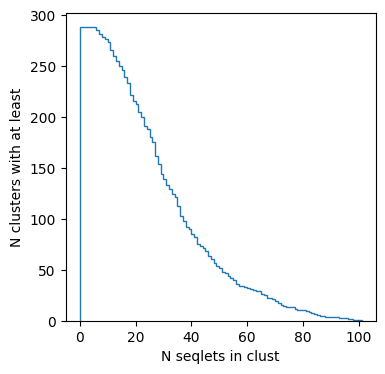

324
Saved PWM File as : /home/sasse/CZS/Projects/ZebraFishDevelopment/Models/psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F_seqletscluster_cwms.meme


In [7]:
from drg_tools.motif_analysis import combine_pwms, torch_compute_similarity_motifs, assign_leftout_to_cluster
import numpy as np
from drg_tools.io_utils import write_meme_file
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time

# Load saved seqlets
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Make it a list and provide the seqlets in shape (l,4) to the algorithm
normed_motifs = [nm.T for nmm in normed_motifs for nm in nmm]
# Compute distance matrix between all seqlets from all cell types
# if return_alignment = True, then it returns the best offsets, and a binary matrix if the forward or reverse motif was aligned
# As distance metric, we are using the pvalue of the correlation coefficient
t0 = time.time()
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(normed_motifs, normed_motifs, 
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
print(f'Distance matrix of size {motif_distance.shape} computed in {time.time()-t0}')
# With a distance matrix, one can use an clustering algorithm that to determine groups
# Agglomerative clustering has the advantage that it is highly interpretable and that we can use a distance threshold
# instead of defining a fixed number of clusters
# We use complete linkage and a threshold of 0.05, i.e. every motif in the cluster has a p-value < 0.05 to all other motifs
# in the same group
t0 = time.time()
clustering = AgglomerativeClustering(n_clusters = None, metric = 'precomputed', linkage = 'complete', 
                                     distance_threshold = 0.05)
clustering.fit(motif_distance)
print(f'Clustering with matrix of size {motif_distance.shape} computed in {time.time()-t0}')
clusters = clustering.labels_

# We save the cluster assignments to a file
np.savetxt(os.path.splitext(seqlet_file)[0]+'cluster.txt', np.array([np.concatenate(motif_names, axis = 0), clusters], dtype = str).T, fmt = '%s')
# Let check how many seqlets are in each cluster
cluster_ids, n_seqlets = np.unique(clusters, return_counts=True)
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
n_seqlets[n_seqlets > 101] == 101
ax.hist(n_seqlets, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.set_xlabel('N seqlets in clust')
ax.set_ylabel('N clusters with at least')
plt.show()


# TODO: Alternatively select a random subset of 10%, compute distance matrix for it, cluster and later assign held out motifs to cluster
# This saves resources but requires more time

# Combine sequences to CWM and save as meme file
cluster_cwms = combine_pwms(normed_motifs, clusters, 1.-motif_distance, offsets, revcomp_matrix)
write_meme_file(cluster_cwms, cluster_ids.astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme', round = 2)



## Normalize motifs, find TFs with TomTom, assign names

In [14]:
# Load the motifs from the meme file
from drg_tools.io_utils import read_meme
import os
import numpy as np

output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
cwm_meme = os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
# Download motif databases here https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
# Load pwms of motif database 
database=os.path.expanduser('~/data/motif_databases/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2TF.meme')
TF_pfms, TFnames, nts = read_meme(database, nameline = 'MOTIF')

# Compute similarity matrix between cwms and pwms with drg and regturn correlation_pvalue
# Transform pfms to pwms
TF_pwms = []
for tfpf in TF_pfms:
    TF_pwms.append(np.log2((tfpf+0.25)/0.25))

from drg_tools.motif_analysis import torch_compute_similarity_motifs
# Potentially modify the cwms with exp, normalize to sum to 1, and create pwm to be more comparable. 
cluster_pwms = []
for clcw in cluster_cwms:
    clcw = np.exp(clcw) # Attributions are for log-scale values
    clcwsum = np.sum(clcw, 1)
    mask = np.where(clcwsum/np.amax(clcwsum) > 0.1)[0]
    clcw = clcw[mask[0]:mask[-1]+1]/clcwsum[:,None]
    cluster_pwms.append(np.log2((clcw+0.25)/0.25))

# Return p-values for correlation
correlation_pvalue = torch_compute_similarity_motifs(cluster_pwms, TF_pwms, metric = 'correlation_pvalue', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False )
print(correlation_pvalue[np.isinf(correlation_pvalue)], correlation_pvalue.shape)

# The algorithm sets negative correlations to be larger than 1
correlation_pvalue[correlation_pvalue>1] = 1
# correct for multiple testing along the axis of the motif database, with bejamini hochberg method
from scipy.stats import false_discovery_control 
correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')

# write tomtom.tsv file for all matches with q < 0.05, and assign TF names to cluster name
cluster_name = []
tomtom = os.path.splitext(seqlet_file)[0]+'cluster_cwms.tomtom.tsv'
obj = open(tomtom, 'w')
obj.write('Query_ID\tTarget_ID\tOptimal_offset\tp-value\tCorrelation\tq-value\tOrientation\n')
for c, cid in enumerate(cluster_ids):
    cname = cid
    if (correlation_qvalue[c] < 0.05).any():
        cname += '('
        sort = np.argsort(correlation_qvalue[c])
        q, p, tid = correlation_qvalue[c][sort], correlation_pvalue[c][sort], TFnames[sort]
        cn = 0 
        for s in range(len(sort)):
            if q[s] < 0.05:
                obj.write(cid+'\t'+tid[s]+'\t.\t'+str(p[s])+'\t'+str(p[s])+'\t'+str(q[s])+'\t.\n')
                if cn < 5:
                    cname += tid[s]+';'
                    cn += 1
        cname = cname.strip(';')+')'
        print(cname, np.sum(q<0.05))
    cluster_name.append(cname)

cluster_name = np.array(cluster_name)

# Alternatively, one can compare the motifs to the motif database with tomtom from tangermeme
# or with the meme suite browser https://meme-suite.org/meme/tools/tomtom
# TODO, use tangermeme tomtom

[] (324, 841)
1(VEZF1;PLAGL2;SP5;KLF15;KLF5) 22
3(NKX6-3;NKX6-2;NKX6-1;MNX1;Dlx3) 51
4(KLF10;SP1;NR2C2;SP2;KLF14) 10
11(HAND2;SNAI3;SNAI1;Npas2;FIGLA) 44
14(GMEB2;ARNT::HIF1A;Arnt;Mlxip) 4
19(NR2C2) 1
20(Arid3a;LIN54;mix-a) 3
23(VEZF1;KLF1;KLF5;SP4;KLF12) 9
24(SP4;KLF14;KLF12;KLF1;SP2) 13
28(NR1I3;NR2C1;HIC2) 3
29(ZBTB14;E2F1;TCFL5;CEBPB;CEBPE) 18
30(KLF14;KLF7;KLF15;ZNF549;ZNF692) 45
31(Hic1;HIC2) 2
32(MGA;EOMES;TBX2;TBX20;ZNF354C) 45
33(HOXA9;HOXD11;HOXC9;HOXB9;HOXC10) 7
37(NR2C2;ZNF692;PLAGL2;KLF10;KLF7) 11
38(ZFP57;CEBPG;RUNX2;Ahr::Arnt) 4
40(KLF3;MAX::MYC;MYCN;MYC;Gli1) 126
41(RAX;MIXL1;HOXA6;GSX1;POU6F1) 66
44(VEZF1;KLF12;SP2;SP4;SP1) 11
49(EMX2;GBX2;MEOX1;RAX;HESX1) 111
51(TBX15;TBX1;MGA;TBX4;TEAD3) 5
54(RFX7;THAP1;Hic1;NFIA;HIC2) 9
56(Ahr::Arnt;TBX1;TBX15;MGA;TBX4) 13
57(Arid3a) 1
63(ESX1;MSX1;LHX9;NKX6-2;Lhx4) 53
64(FOXC1;SOX10;FOXL1;FOXG1;FOXB1) 17
65(ZBTB32;ZSCAN29;MXI1;DMRT3) 4
67(GMEB2) 1
70(KLF15;TFDP1;KLF12;SP2;SP1) 40
74(MAZ;ZNF148;VEZF1;ZNF281;KLF4) 27
76(CUX1;ONECUT2;

## Plot motifs in tree with detected number of occurrances, and mean, and max effect

17 clusters have more than 10 seqlets


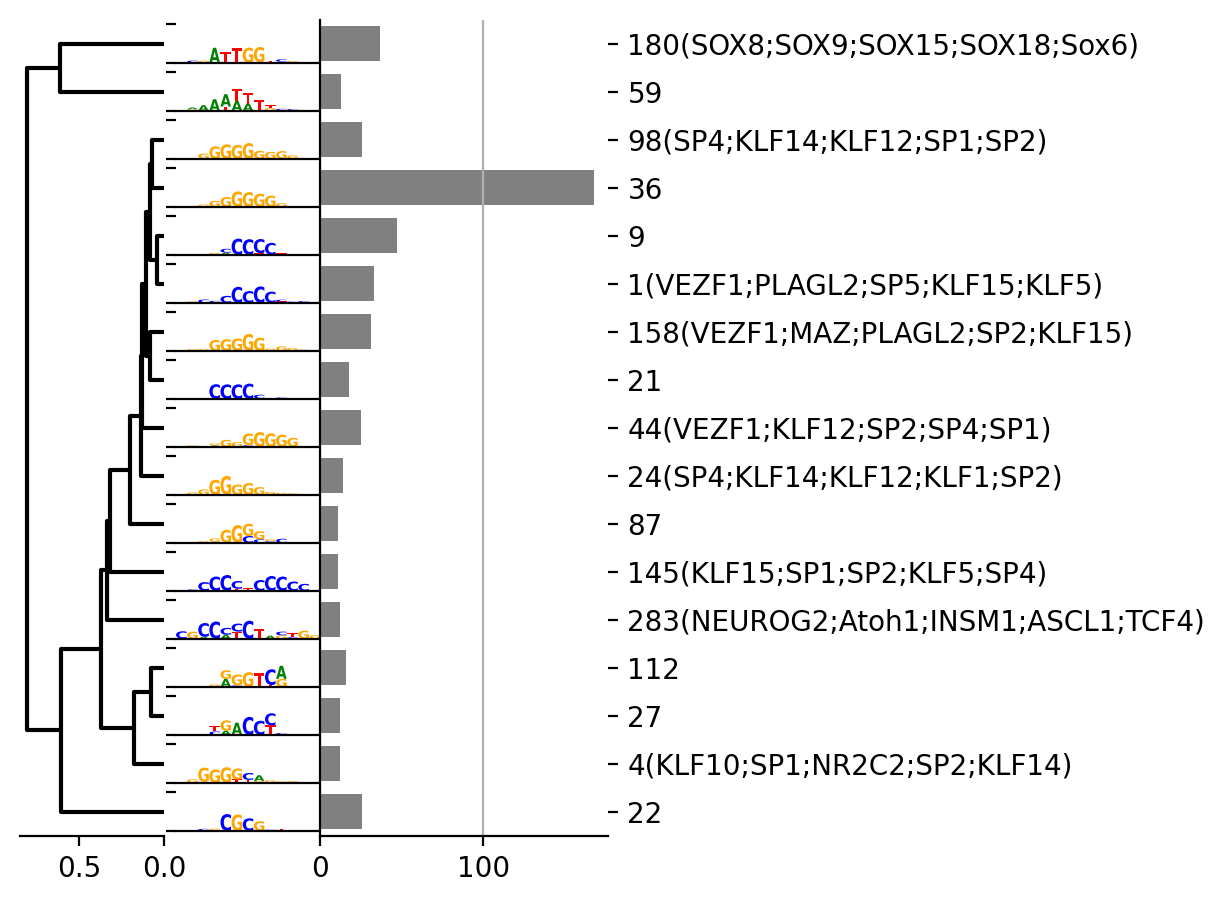

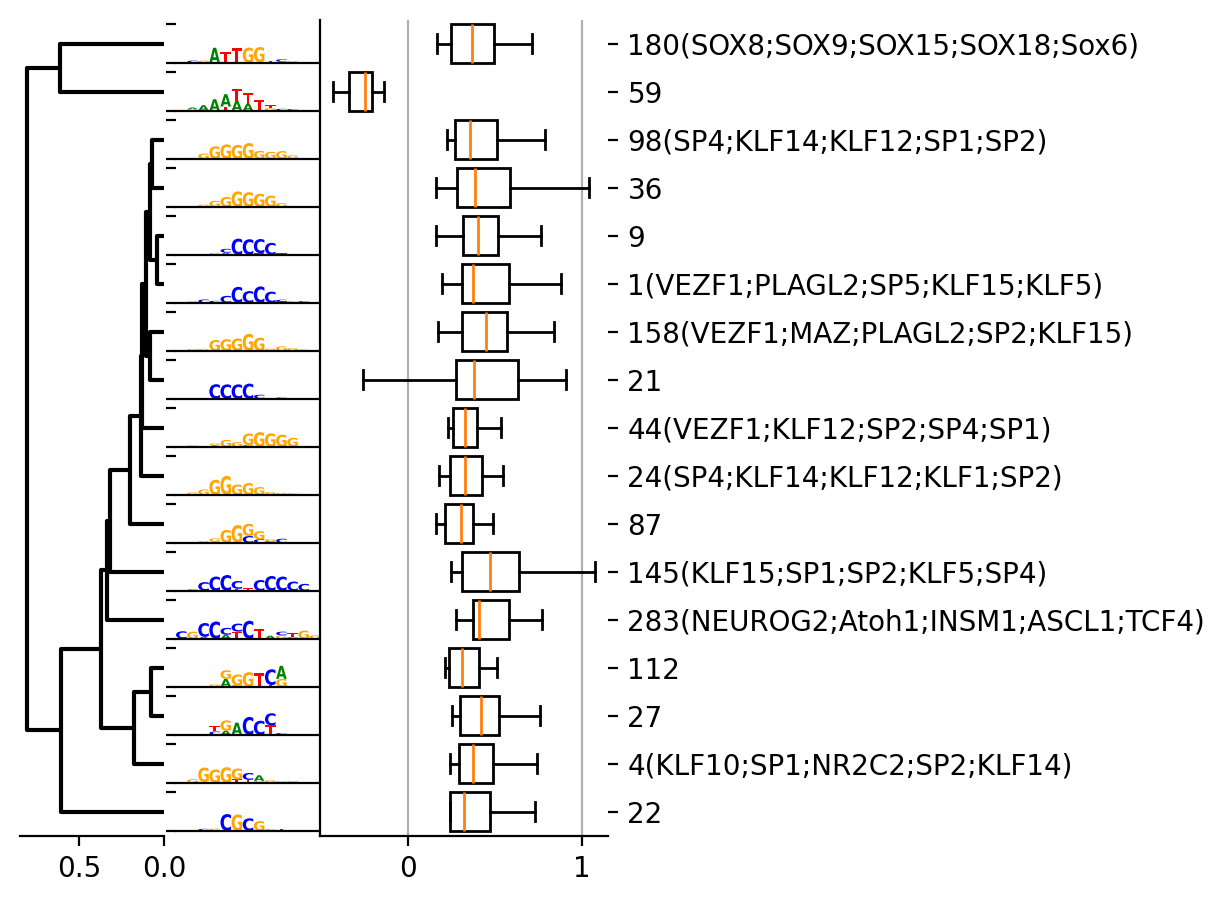

(None, [4, 1, 6, 12, 16, 13, 10, 5, 8, 3, 14, 0, 2, 7, 11, 9, 15])

In [55]:
import drg_tools.plotlib as drgplt

# Of the hundreds of clusters, let's restrict the plot to clusters in neural.crest and large clusters of n > 10
# Load saved seqlets
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

motif_names = np.concatenate(motif_names, axis = 0)
motif_max_effect = np.concatenate(motif_max_effect, axis = 0)

# Load cluster motifs and ids
cwm_meme = os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# We load the cluster assignments from file
cluster_file = np.genfromtxt(os.path.splitext(seqlet_file)[0]+'cluster.txt', dtype = str)
motif_names, clusters = cluster_file[:,0], cluster_file[:,1].astype(int)


motif_mask = np.array(['neural.crest' in mf for mf in motif_names])
cluster_ids_nc, n_seqlets_nc = np.unique(clusters[motif_mask], return_counts=True)
n_seqlets = np.zeros(len(cluster_ids))

# This only works if clusters and cluster_ids are integer, otherwise cluster_ids_nc will not be sorted as integer but as string
n_seqlets[np.isin(cluster_ids, cluster_ids_nc)] = n_seqlets_nc
cluster_mask = n_seqlets > 10
print(f'{np.sum(cluster_mask)} clusters have more than 10 seqlets')

selected_cluster_cwms = [cw for c, cw in enumerate(cluster_cwms) if cluster_mask[c]]
# Compute the correlation distance matrix between the selected cluster motifs
cwm_correlation = torch_compute_similarity_motifs(selected_cluster_cwms, selected_cluster_cwms, metric = 'correlation', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False)

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = n_seqlets[cluster_mask].reshape(-1,1), # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {'barplot':True} # kwargs fro plot_distribution
                 )


# Collect the max-effects of the different motif clusters for a specific cell types from motif_mean_effect
cluster_effect_sizes = []
for ci in cluster_ids[cluster_mask]:
    cluster_effect_sizes.append(motif_max_effect[(clusters == ci)*(motif_mask)])

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = cluster_effect_sizes, # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
                 )
                            


## Summarize all effects across all cell types to matrix and plot with tree

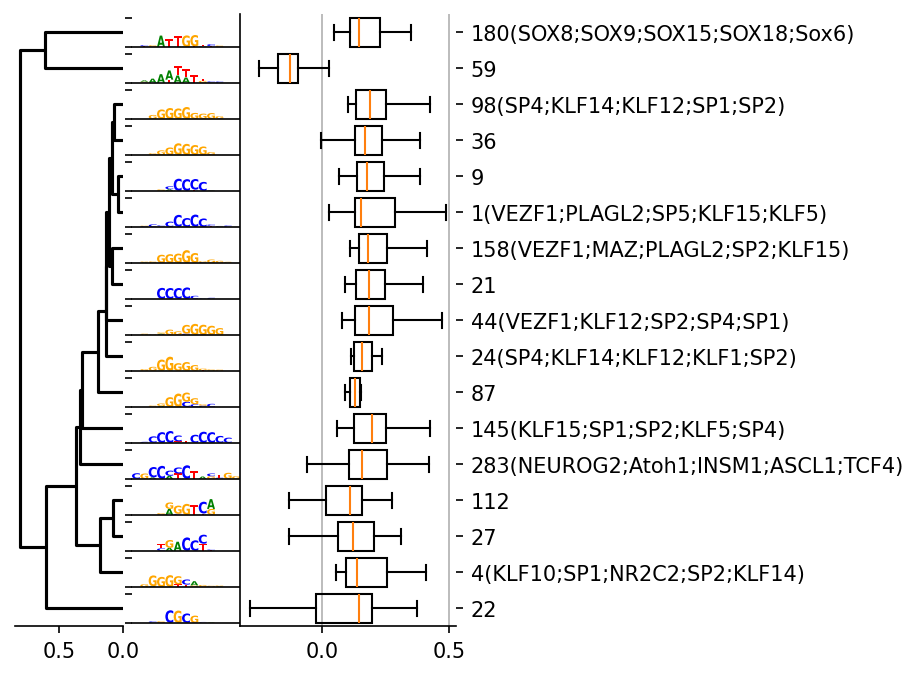

-0.23265919089317322 0.23265919089317322


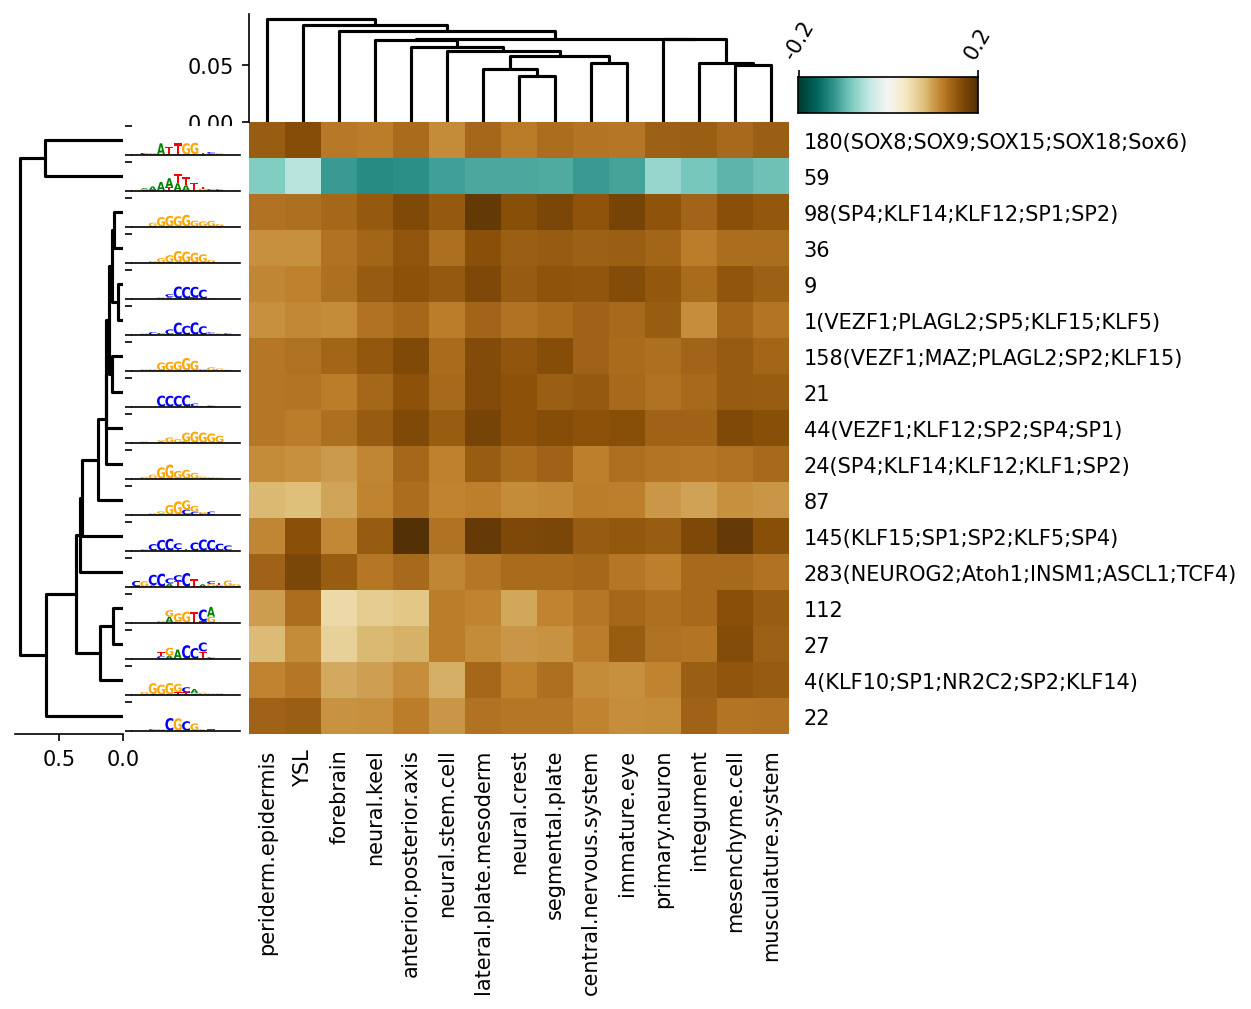

([11, 14, 2, 9, 0, 10, 5, 8, 13, 1, 3, 12, 4, 6, 7],
 [4, 1, 6, 12, 16, 13, 10, 5, 8, 3, 14, 0, 2, 7, 11, 9, 15])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

def shared_borders(p_list):
    n = len(p_list)
    shared_matrix = np.zeros((n, n), dtype=bool)
    for i in range(n):
        for j in range(i, n):
            shared_matrix[i, j] = np.intersect1d(p_list[i], p_list[j]).size > 0
    return shared_matrix

from scipy.sparse.csgraph import connected_components
def get_groups(shared_matrix):
    # Use connected_components to find groups
    n_components, labels = connected_components(csgraph=shared_matrix, directed=False)
    # Group indices by component
    groups = [np.where(labels == i)[0].tolist() for i in range(n_components)]
    return groups

def get_borders_of_groups(p_list, groups):
    new_borders = [np.unique(np.concatenate([p_list[gi] for gi in g])) for g in groups]
    return new_borders

def get_unique_motif_positions(p_list):
    shared_matrix = shared_borders(p_list)
    groups = get_groups(shared_matrix)
    unique_motif_borders = get_borders_of_groups(p_list, groups)
    return unique_motif_borders

def signed_absmax(arr, axis):
    """
    Find the absolute maximum with its original sign along a specified axis.
    Parameters:
    -----------
        arr (np.ndarray): Input array.
        axis (int): Axis along which to find the absolute maximum.
    Returns:
    --------
        np.ndarray: Array of absolute maximum values with their original sign.
    """
    # Get the indices of the absolute maximum values along the specified axis
    indices = np.argmax(np.abs(arr), axis=axis)
    
    # Use expand_dims to align the indices with the input array's shape
    expanded_indices = np.expand_dims(indices, axis=axis)
    
    # Extract the values with their original sign using take_along_axis
    abs_max_with_sign = np.take_along_axis(arr, expanded_indices, axis=axis)
    
    # Squeeze the result to remove the singleton dimension
    return np.squeeze(abs_max_with_sign, axis=axis)


# Load saved seqlets
output_path = os.path.expanduser('~/CZS/Projects/ZebraFishDevelopment/Models/')
model_stem = 'psd.bulk.zfish_atac.10hpf.lg1x.qnonoh-cv0-0_MSEk300l19FfGELUmax2vlCosssft51_dc1i1d1s1l7r1_tc5dNoned1s1r6l7ma2nfc2s512fdo0.1tr4e-06SGD0.9bs64-F'
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Load cluster motifs and ids
cwm_meme = os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# We load the cluster assignments from file
cluster_file = np.genfromtxt(os.path.splitext(seqlet_file)[0]+'cluster.txt', dtype = str)
motif_names, clusters = cluster_file[:,0], cluster_file[:,1].astype(int)

# from motif_names, assign peak name, track, and positions to motif
# TODO save this in seqlet file 
motif_borders = np.concatenate(motif_borders, axis = 0)
motif_sequence, motif_track, motif_positions = [], [], []
for m, mn in enumerate(motif_names):
    mn = mn.split('_')
    motif_sequence.append(mn[0])
    motif_track.append(mn[1])
    motif_positions.append(np.arange(motif_borders[m,0],motif_borders[m,1],dtype = int))
motif_sequence, motif_track, motif_positions = np.array(motif_sequence), np.array(motif_track), np.array(motif_positions, dtype = object)


# For each cluster, find all the instances of a motif
# align them if they are from two different cell types
# now extract max and mean attribution across all cell types
stats = np.sum(gradattr * selected_sequences[:, None], axis = -2)
#print(stats.shape)

# TODO put this in a function
cluster_effect_sizes = []
#print(clusters, cluster_ids, clusters, header)
cluster_median_matrix = np.zeros((len(cluster_ids), len(header)))
for c, ci in enumerate(cluster_ids):
    cimask = clusters == ci
    cluster_effect = []
    # find unique sequences with that motif in one of the cell types
    uni_sequence = np.unique(motif_sequence[cimask])
    #print(uni_sequence)
    # for every sequence determine the joint start and end of the motifs
    for us in uni_sequence:
        unisemask = (motif_sequence == us)*cimask
        unipos = get_unique_motif_positions(motif_positions[unisemask])
        #print(unipos)
        seq_stats = stats[list(selected_names).index(us)]
        for up in unipos:
            cluster_effect.append(signed_absmax(seq_stats[:,up[0]:up[1]],-1))
            #print(cluster_effect[-1])
    cluster_effect_sizes.append(np.array(cluster_effect))
    cluster_median_matrix[c] = np.median(cluster_effect, axis = 0)

# Plot box plot again for neural.crest but now including the times a motif shows up in another cell type
drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 150, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = [ces[:,8] for c, ces in enumerate(cluster_effect_sizes) if cluster_mask[c]], # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
                 )

# Plot heat map with all median effect sizes for all cell types.
drgplt.plot_heatmap(cluster_median_matrix[cluster_mask], # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 sortx = 'single',
                 measurex = 'euclidean',
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 xticklabels = header,
                 showdpi = 150, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 vmin = -np.amax(np.abs(cluster_median_matrix[cluster_mask])),
                 vmax = np.amax(np.abs(cluster_median_matrix[cluster_mask])),
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = False, # if True, only tree is plotted
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
)   
